In [1]:
"""author: Vetivert? 💐 
created: 28/05/2025 @ 01:47:24"""

'author: Vetivert? 💐 \ncreated: 28/05/2025 @ 01:47:24'

# LOAD DATA

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import pandas as pd 
import seaborn as sns 

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV 
from sklearn.preprocessing import StandardScaler, label_binarize 
from sklearn.metrics import (classification_report, roc_auc_score, roc_curve, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, f1_score, 
                             mean_squared_error, r2_score, roc_auc_score, make_scorer) 

import tensorflow as tf 
from tensorflow.keras.models import Sequential, Model # type: ignore
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Masking, SpatialDropout1D, Layer, BatchNormalization # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # type: ignore
import tensorflow.keras.backend as K # type: ignore

import sys
import os

current_dir = os.path.abspath('')

parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from src.utils.prefix_path import *
# from src.utils.models import *
from src.utils.functions import *

2025-05-30 01:22:32.600296: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 01:22:32.689465: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 01:22:32.756906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748560952.840205   32638 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748560952.864710   32638 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748560953.017638   32638 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [207]:
# Load dataset
df = pd.read_csv(FULL_DATA_PATH, sep=";", header=3) #separator is ;
# df = df.apply(pd.to_numeric, errors='coerce')

# Drop redundant cols + rows
df.drop(REDUNDANT_ROWS, inplace=True)

df.reset_index(drop=True, inplace=True) #reset index
df.drop(REDUNDANT_COLS, axis=1, inplace=True)

df.fillna(FILLNA_VALUES) #df[1] = df[1].fillna(0)
df['Other'] = pd.to_numeric(df['Other'], errors='coerce').fillna(1) #addtional diseases
df = df.replace('8(nặng xin về)', 8)
df = df.replace('(17/9)3.7', 3.7)

for i in HEART_INDEX:
    df[i] = pd.to_numeric(df[i], errors='coerce')
    print(f"{i}: {df[str(i)].mean()}")
print("\nDiastolic BP < 80: Huyết áp tối ưu \nSystolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp")

# df.drop(HEART_INDEX, axis=1, inplace=True)

uniques, counts = np.unique(df['Diagnosis'], return_counts=True)
print('\nDiagnosis\'s classes: ',dict(zip(uniques, np.round(counts * 100 / len(df['Diagnosis']), 2))))
df['Diagnosis'] = np.where(df['Diagnosis'] == '3', '2', df['Diagnosis'])
df['Day of illness'] = np.where(df['Day of illness'] == '55', '5', df['Day of illness'])
df['Systolic BP'] = np.where(df['Systolic BP'] == 1120, 120, df['Systolic BP'])



# hematoma group
hema = df[HEMATOMA_COLS]
hema = hema.assign(stacked=hema.astype(str).agg(''.join, axis=1))
hema['stacked'] = (pd.to_numeric(hema['stacked'], errors='coerce'))
hema['stacked_int'] = np.where(hema['stacked'] == 0, 0, 1)
# Get the integer position of the first hematoma column
hematoma_idx = df.columns.get_indexer([HEMATOMA_COLS[0]])[0]
#hematoma_idx.item() -> extract the value from np.int64 into native Python int
df.insert(hematoma_idx.item(), 'hematoma', hema['stacked_int']) #get col index by its name
df.drop(HEMATOMA_COLS, axis=1, inplace=True)

# bleeding group
bleed = df[BLEEDING_COLS]
bleed = bleed.assign(stacked=bleed.astype(str).agg(''.join, axis=1))
bleed['stacked'] = (pd.to_numeric(bleed['stacked'], errors='coerce'))
bleed['stacked_int'] = np.where(bleed['stacked'] == 0, 0, 1)
# Get the integer position of the first bleeding column
bleeding_idx = df.columns.get_indexer([BLEEDING_COLS[0]])[0]
df.insert(bleeding_idx.item(), 'Mucosa membrane bleeding', bleed['stacked_int'])
df.drop(BLEEDING_COLS, axis=1, inplace=True)

# additional diseases group
add_diseases = df[ADDITIONAL_DISEASES]
add_diseases = add_diseases.assign(stacked=add_diseases.astype(str).agg(''.join, axis=1))
add_diseases['stacked'] = (pd.to_numeric(add_diseases['stacked'], errors='coerce'))
add_diseases['stacked_int'] = np.where(add_diseases['stacked'] == 0, 0, 1)
# Get the integer position of the first additional diseases column
additional_diseases_idx = df.columns.get_indexer([ADDITIONAL_DISEASES[0]])[0]
df.insert(additional_diseases_idx.item(), 'additional_diseases', add_diseases['stacked_int'])
# df.insert(df.columns.get_loc(ADDITIONAL_DISEASES[0]), 'additional_diseases', add_diseases['stacked_int'])
df.drop(ADDITIONAL_DISEASES, axis=1, inplace=True)


Pulse rate: 89.60148514851485
Systolic BP: 117.25
Diastolic BP: 70.63861386138613

Diastolic BP < 80: Huyết áp tối ưu 
Systolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp

Diagnosis's classes:  {'1': np.float64(56.4), '2': np.float64(39.66), '3': np.float64(3.94)}


/tmp/ipykernel_32638/364845287.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('8(nặng xin về)', 8)
/tmp/ipykernel_32638/364845287.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(hematoma_idx.item(), 'hematoma', hema['stacked_int']) #get col index by its name
/tmp/ipykernel_32638/364845287.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(a

# SPLIT TRAIN TEST

In [148]:
df.drop(HEART_INDEX, axis=1, inplace=True)

In [166]:
df_set = df.loc[:, 'Gende':'Oliguria'].copy().fillna(0)
df_set = df_set.apply(pd.to_numeric, errors='coerce')

x1_train, x1_test, y1_train, y1_test = train_test_split(df_set, df['Diagnosis'], \
                                                    test_size=0.2, random_state=17, stratify=df['Diagnosis'])
x1_features = x1_train.columns

# x1_train, x1_test, y1_train, y1_test = x1_train.to_numpy(), x1_test.to_numpy(), y1_train.to_numpy(), y1_test.to_numpy()

print('x1_train shape: ', x1_train.shape, 'y1_train shape: ',  y1_train.shape)
print('x1_test shape: ', x1_test.shape, 'y1_test shape: ',  y1_test.shape)
uniques, counts = np.unique(y1_test, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y1_test), 2))))

x1_train shape:  (324, 24) y1_train shape:  (324,)
x1_test shape:  (82, 24) y1_test shape:  (82,)
percentage of classes:  {'1': np.float64(56.1), '2': np.float64(43.9)}


In [ ]:
# x1_train = x1_train.apply(pd.to_numeric, errors='coerce')
# x1_test = x1_test.apply(pd.to_numeric, errors='coerce')
# y1_train = pd.to_numeric(y1_train, errors='coerce')
# y1_test = pd.to_numeric(y1_test, errors='coerce')

In [167]:
x1_train = x1_train.to_numpy()
y1_train = y1_train.to_numpy()
x1_test = x1_test.to_numpy()
y1_test = y1_test.to_numpy()

x1_train = x1_train.astype(np.float64)
y1_train = y1_train.astype(np.int64)
x1_test = x1_test.astype(np.float64)
y1_test = y1_test.astype(np.int64)

y1_train = y1_train - 1
y1_test = y1_test - 1

# x1_train = x1_train.reshape(x1_train.shape[0], 1, 24)

# x1_test = x1_test.reshape(x1_test.shape[0], 1, 24)


In [168]:
print(y1_test)

[0 1 1 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0
 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0
 0 0 1 0 0 0 0 1]


In [30]:
print(y1_train[0])

0


# LSTM

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5405 - auc_5: 0.4830 - loss: 0.6998 - precision_5: 0.2864 - recall_5: 0.0076 - val_accuracy: 0.0122 - val_auc_5: 0.0000e+00 - val_loss: 0.9685 - val_precision_5: 1.0000 - val_recall_5: 0.0244
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5704 - auc_5: 0.5143 - loss: 0.6829 - precision_5: 0.4607 - recall_5: 0.0441 - val_accuracy: 0.0366 - val_auc_5: 0.0000e+00 - val_loss: 0.9643 - val_precision_5: 1.0000 - val_recall_5: 0.0610
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5750 - auc_5: 0.5536 - loss: 0.6820 - precision_5: 0.5767 - recall_5: 0.1492 - val_accuracy: 0.0122 - val_auc_5: 0.0000e+00 - val_loss: 1.0130 - val_precision_5: 1.0000 - val_recall_5: 0.0244
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5717 - auc_5: 0.5937 - loss: 0.6813 - precision_5: 0.6916 - recall_5: 0.1510 - val_accuracy: 0.0122 - val_auc_5: 0.0000e+00 - val_loss: 1.0001 - val_precision_5: 1

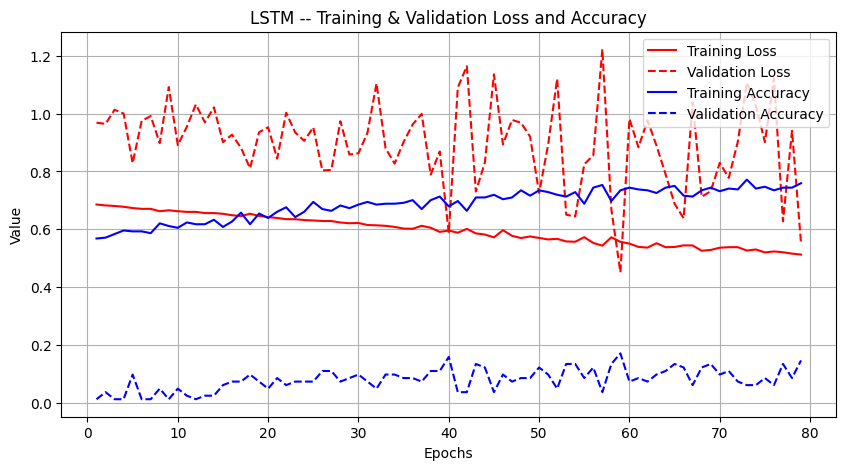

In [74]:
# Define the BiLSTM model
model = Sequential([
    Input(shape=(1, 24)),  # Input shape: (timesteps, features)
    Masking(mask_value=-1.0),  # Ignores padding
    LSTM(24),  #, kernel_initializer='he_uniform'
    Dense(1, activation='sigmoid')  # 3-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(),
                 tf.keras.metrics.Precision(), 
                 tf.keras.metrics.Recall()])

# Train the model
history = model.fit(
    x1_train, y1_train,  
    epochs=100,
    batch_size=16,
    validation_data=(x1_test, y1_test),
    callbacks=[EarlyStopping(patience=20)]
)

# Extract values
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot both accuracy and loss
plt.figure(figsize=(10, 5))

# Left Y-axis: Loss
plt.plot(epochs, train_loss, 'r-', label="Training Loss")
plt.plot(epochs, val_loss, 'r--', label="Validation Loss")

# Right Y-axis: Accuracy
plt.plot(epochs, train_acc, 'b-', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b--', label="Validation Accuracy")

# Labels & Legends
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("LSTM -- Training & Validation Loss and Accuracy")
plt.legend()
plt.grid()

# Show plot
plt.show()

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.6086 - auc_6: 0.4464 - loss: 0.6770 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.9289 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5789 - auc_6: 0.6115 - loss: 0.6769 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_accuracy: 0.0122 - val_auc_6: 0.0000e+00 - val_loss: 0.9080 - val_precision_6: 1.0000 - val_recall_6: 0.0122
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5426 - auc_6: 0.5353 - loss: 0.6888 - precision_6: 0.6894 - recall_6: 0.0245 - val_accuracy: 0.0366 - val_auc_6: 0.0000e+00 - val_loss: 0.8861 - val_precision_6: 1.0000 - val_recall_6: 0.0366
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5720 - auc_6: 0.5539 - loss: 0.6813 - precision_6: 0.7523 - recall_6: 0.0288 - val_accuracy: 0.0366 - val_auc_6: 0.0000e+00 - val_loss:

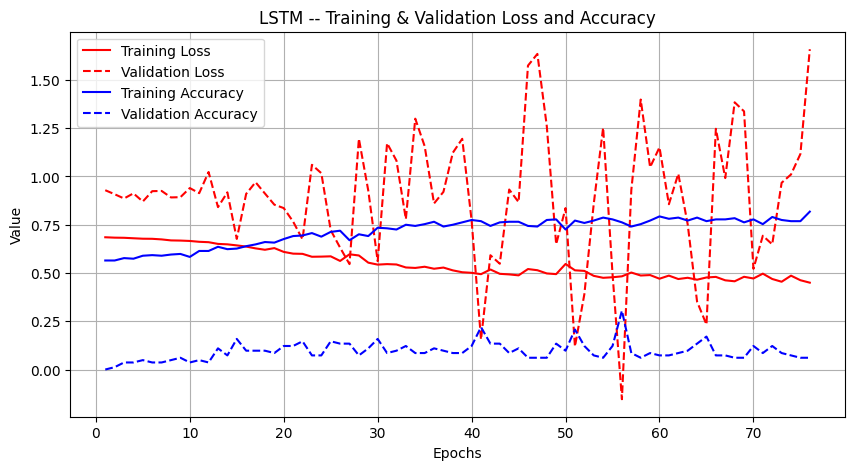

In [75]:
# Define the BiLSTM model
model_S = Sequential([
    Input(shape=(1, 24)),  # Input shape: (timesteps, features)
    Masking(mask_value=-1.0),  # Ignores padding
    LSTM(24, return_sequences=True),  #, kernel_initializer='he_uniform'
    # Dropout(0.3),
    LSTM(24),  #, kernel_initializer='he_uniform'
    # Dropout(0.3),
    Dense(1, activation='sigmoid')  # 3-class classification
])

# Compile the model
model_S.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(),
                 tf.keras.metrics.Precision(), 
                 tf.keras.metrics.Recall()])

# Train the model
history = model_S.fit(
    x1_train, y1_train,  
    epochs=100,
    batch_size=16,
    validation_data=(x1_test, y1_test),
    callbacks=[EarlyStopping(patience=20)]
)

# Extract values
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot both accuracy and loss
plt.figure(figsize=(10, 5))

# Left Y-axis: Loss
plt.plot(epochs, train_loss, 'r-', label="Training Loss")
plt.plot(epochs, val_loss, 'r--', label="Validation Loss")

# Right Y-axis: Accuracy
plt.plot(epochs, train_acc, 'b-', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b--', label="Validation Accuracy")

# Labels & Legends
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("LSTM -- Training & Validation Loss and Accuracy")
plt.legend()
plt.grid()

# Show plot
plt.show()

# SA-LSTM

In [8]:
def prepare_data_for_lstm(X, y):
    """Prepare data for LSTM model with attention"""
    # Scale features
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Convert target to binary format
    # y_binary = (y == '2').astype(int)  # Assuming class '2' is the positive class
    
    # Reshape input to 3D format expected by LSTM: [samples, timesteps, features]
    # For this model, we use the entire feature vector as a single timestep sequence
    X_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
    
    return X_reshaped, y, scaler

def prepare_sequence_data(X, y, n_steps=3):
    """
    Prepare data by splitting features into groups that are treated as timesteps
    This allows the attention mechanism to focus on different feature groups
    
    Args:
        X: Feature DataFrame
        y: Target values
        n_steps: Number of timesteps to divide features into
    """
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Convert target to binary format
    # y_binary = (y == '2').astype(int)
    
    # Calculate features per timestep
    n_features = X_scaled.shape[1]
    n_features_per_step = n_features // n_steps
    
    # Reshape into [samples, timesteps, features_per_step]
    X_reshaped = np.zeros((X_scaled.shape[0], n_steps, n_features_per_step))
    
    for i in range(n_steps):
        start_idx = i * n_features_per_step
        end_idx = start_idx + n_features_per_step if i < n_steps - 1 else n_features
        step_features = X_scaled[:, start_idx:end_idx]
        
        # Handle the last step which might have different number of features
        if step_features.shape[1] < n_features_per_step:
            # Pad with zeros if needed
            padding = np.zeros((X_scaled.shape[0], n_features_per_step - step_features.shape[1]))
            step_features = np.column_stack((step_features, padding))
            
        X_reshaped[:, i, :] = step_features
    
    return X_reshaped, y, scaler

In [ ]:
# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Alignment scores. [batch_size, seq_len, 1]
        e = K.tanh(K.dot(x, self.W) + self.b)
        
        # Remove dimension of size 1. [batch_size, seq_len]
        e = K.squeeze(e, axis=-1)
        
        # Compute the weights. [batch_size, seq_len]
        alpha = K.softmax(e)
        
        # Reshape to [batch_size, seq_len, 1]
        alpha = K.expand_dims(alpha, axis=-1)
        
        # Compute the context vector. [batch_size, features]
        context = x * alpha
        context = K.sum(context, axis=1)
        
        return context

def create_lstm_with_attention(input_shape, dropout_rate=0.2):
    """
    Create an LSTM model with Spatial Dropout and Attention for binary classification
    
    Args:
        input_shape: Tuple (timesteps, features) specifying input dimensions
        dropout_rate: Dropout rate to prevent overfitting
    
    Returns:
        Compiled Keras LSTM model with attention
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Spatial Dropout layer
    # This helps with overfitting by dropping entire feature maps
    x = BatchNormalization()(inputs)
    
    # LSTM layer
    x = LSTM(24, return_sequences=True)(x)
    x = SpatialDropout1D(dropout_rate)(x)
    
    # Attention layer
    x = AttentionLayer()(x)

    # Dropout for regularization
    x = Dropout(dropout_rate)(x)
    
    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), 
                 tf.keras.metrics.Precision(), 
                 tf.keras.metrics.Recall()]
    )
    
    return model


In [165]:
# Assuming x1_train, y1_train, x1_test, y1_test are available from your notebook

# Prepare data 
# Option 1: Single timestep with all features
X_train_lstm, y_train_lstm, scaler = prepare_data_for_lstm(x1_train, y1_train)
# print("X_train_lstm shape:", X_train_lstm.shape)
X_test_lstm, y_test_lstm, _ = prepare_data_for_lstm(x1_test, y1_test)

# Option 2: Multiple timesteps (feature groups)
# X_train_lstm, y_train_lstm, scaler = prepare_sequence_data(x1_train, y1_train, n_steps=4)
# X_test_lstm, y_test_lstm, _ = prepare_sequence_data(x1_test, y1_test, n_steps=4)

# Create model
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])  # (timesteps, features)
model = create_lstm_with_attention(input_shape)

# Model summary
model.summary()

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ModelCheckpoint('best_lstm_attention_model.h5', save_best_only=True, monitor='val_loss'),
    # Optionally add learning rate reduction callback
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001
    )
]

# Calculate class weights - important for imbalanced data
from sklearn.utils.class_weight import compute_class_weight
unique_classes = np.unique(y_train_lstm)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_lstm)
class_weight_dict = {i: weight for i, weight in zip(unique_classes, class_weights)}
print("Class weights:", class_weight_dict)

# Train model
history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)



Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_47 (InputLayer)     │ (None, 1, 24)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 1, 24)          │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_72 (LSTM)                  │ (None, 1, 24)          │         4,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_52            │ (None, 1, 24)          │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ middle_attention_layer_3        │ (None, 1, 24)          │            25 │
│ (middleAttentionLayer)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_73 (LSTM)                  │ (None, 1, 24)          │         4,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_53            │ (None, 1, 24)          │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_44              │ (None, 24)             │            25 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,579 (37.42 KB)

 Trainable params: 9,531 (37.23 KB)

 Non-trainable params: 48 (192.00 B)

Class weights: {np.int64(0): np.float64(0.8852459016393442), np.int64(1): np.float64(1.148936170212766)}
Epoch 1/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.5625 - auc_21: 0.5275 - loss: 0.7003 - precision_21: 0.5333 - recall_21: 0.5333

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.6062 - auc_21: 0.6000 - loss: 0.6920 - precision_21: 0.5457 - recall_21: 0.6155 - val_accuracy: 0.6000 - val_auc_21: 0.6721 - val_loss: 0.6902 - val_precision_21: 0.5000 - val_recall_21: 0.6923 - learning_rate: 0.0010
Epoch 2/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6562 - auc_21: 0.7745 - loss: 0.6917 - precision_21: 0.6111 - recall_21: 0.7333

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6129 - auc_21: 0.6958 - loss: 0.6918 - precision_21: 0.5659 - recall_21: 0.6604 - val_accuracy: 0.6000 - val_auc_21: 0.7036 - val_loss: 0.6882 - val_precision_21: 0.5000 - val_recall_21: 0.6923 - learning_rate: 0.0010
Epoch 3/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7188 - auc_21: 0.8355 - loss: 0.6674 - precision_21: 0.5556 - recall_21: 0.9091

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7157 - auc_21: 0.7572 - loss: 0.6833 - precision_21: 0.6333 - recall_21: 0.7980 - val_accuracy: 0.6000 - val_auc_21: 0.7441 - val_loss: 0.6858 - val_precision_21: 0.5000 - val_recall_21: 0.6538 - learning_rate: 0.0010
Epoch 4/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6250 - auc_21: 0.6232 - loss: 0.6616 - precision_21: 0.3846 - recall_21: 0.5556

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6320 - auc_21: 0.7014 - loss: 0.6794 - precision_21: 0.5288 - recall_21: 0.6448 - val_accuracy: 0.5846 - val_auc_21: 0.7480 - val_loss: 0.6838 - val_precision_21: 0.4865 - val_recall_21: 0.6923 - learning_rate: 0.0010
Epoch 5/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6562 - auc_21: 0.7229 - loss: 0.6721 - precision_21: 0.5333 - recall_21: 0.6667

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6389 - auc_21: 0.7216 - loss: 0.6824 - precision_21: 0.5651 - recall_21: 0.7426 - val_accuracy: 0.5692 - val_auc_21: 0.7638 - val_loss: 0.6819 - val_precision_21: 0.4750 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 6/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6875 - auc_21: 0.7021 - loss: 0.7168 - precision_21: 0.7500 - recall_21: 0.7500

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6973 - auc_21: 0.7702 - loss: 0.6900 - precision_21: 0.6674 - recall_21: 0.7971 - val_accuracy: 0.5846 - val_auc_21: 0.7712 - val_loss: 0.6787 - val_precision_21: 0.4872 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 7/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7188 - auc_21: 0.8030 - loss: 0.6592 - precision_21: 0.5556 - recall_21: 0.9091

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7019 - auc_21: 0.7885 - loss: 0.6729 - precision_21: 0.6201 - recall_21: 0.7897 - val_accuracy: 0.6308 - val_auc_21: 0.7845 - val_loss: 0.6745 - val_precision_21: 0.5278 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 8/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6875 - auc_21: 0.7832 - loss: 0.6842 - precision_21: 0.6500 - recall_21: 0.8125

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6940 - auc_21: 0.7877 - loss: 0.6763 - precision_21: 0.6520 - recall_21: 0.7520 - val_accuracy: 0.6769 - val_auc_21: 0.7919 - val_loss: 0.6697 - val_precision_21: 0.5758 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 9/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - auc_21: 0.8216 - loss: 0.6733 - precision_21: 0.7059 - recall_21: 0.8000

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6916 - auc_21: 0.7903 - loss: 0.6678 - precision_21: 0.6250 - recall_21: 0.7680 - val_accuracy: 0.7077 - val_auc_21: 0.7894 - val_loss: 0.6636 - val_precision_21: 0.6129 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 10/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - auc_21: 0.8333 - loss: 0.6623 - precision_21: 0.7143 - recall_21: 0.7143

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7180 - auc_21: 0.8217 - loss: 0.6600 - precision_21: 0.6640 - recall_21: 0.7595 - val_accuracy: 0.6923 - val_auc_21: 0.8028 - val_loss: 0.6576 - val_precision_21: 0.5938 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 11/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5938 - auc_21: 0.8385 - loss: 0.6328 - precision_21: 0.3529 - recall_21: 0.7500

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6920 - auc_21: 0.8227 - loss: 0.6491 - precision_21: 0.5876 - recall_21: 0.8232 - val_accuracy: 0.6923 - val_auc_21: 0.8037 - val_loss: 0.6510 - val_precision_21: 0.5938 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 12/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7188 - auc_21: 0.7403 - loss: 0.6469 - precision_21: 0.5556 - recall_21: 0.9091

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7422 - auc_21: 0.8146 - loss: 0.6385 - precision_21: 0.6320 - recall_21: 0.8712 - val_accuracy: 0.7231 - val_auc_21: 0.8057 - val_loss: 0.6406 - val_precision_21: 0.6333 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 13/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7812 - auc_21: 0.8333 - loss: 0.6227 - precision_21: 0.7333 - recall_21: 0.7857

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7484 - auc_21: 0.8075 - loss: 0.6326 - precision_21: 0.6999 - recall_21: 0.7720 - val_accuracy: 0.7385 - val_auc_21: 0.8102 - val_loss: 0.6292 - val_precision_21: 0.6552 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 14/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7188 - auc_21: 0.7718 - loss: 0.6372 - precision_21: 0.6471 - recall_21: 0.7857

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7417 - auc_21: 0.8285 - loss: 0.6175 - precision_21: 0.6729 - recall_21: 0.8091 - val_accuracy: 0.7385 - val_auc_21: 0.8092 - val_loss: 0.6153 - val_precision_21: 0.6552 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 15/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8125 - auc_21: 0.9114 - loss: 0.5573 - precision_21: 0.6429 - recall_21: 0.9000

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7448 - auc_21: 0.8240 - loss: 0.5984 - precision_21: 0.6666 - recall_21: 0.7840 - val_accuracy: 0.7538 - val_auc_21: 0.8121 - val_loss: 0.5999 - val_precision_21: 0.6786 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 16/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6562 - auc_21: 0.7676 - loss: 0.6169 - precision_21: 0.6667 - recall_21: 0.6250

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7266 - auc_21: 0.8155 - loss: 0.5937 - precision_21: 0.7096 - recall_21: 0.6964 - val_accuracy: 0.7692 - val_auc_21: 0.8102 - val_loss: 0.5873 - val_precision_21: 0.7037 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 17/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8438 - auc_21: 0.8829 - loss: 0.5297 - precision_21: 0.8000 - recall_21: 0.8571

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7618 - auc_21: 0.8402 - loss: 0.5621 - precision_21: 0.7196 - recall_21: 0.7403 - val_accuracy: 0.7538 - val_auc_21: 0.8126 - val_loss: 0.5780 - val_precision_21: 0.6786 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 18/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8125 - auc_21: 0.8472 - loss: 0.5344 - precision_21: 0.7857 - recall_21: 0.7857

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7475 - auc_21: 0.8152 - loss: 0.5634 - precision_21: 0.6859 - recall_21: 0.7552 - val_accuracy: 0.7538 - val_auc_21: 0.8126 - val_loss: 0.5715 - val_precision_21: 0.6786 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 19/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7812 - auc_21: 0.8625 - loss: 0.5602 - precision_21: 0.6471 - recall_21: 0.9167

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7697 - auc_21: 0.8440 - loss: 0.5443 - precision_21: 0.6929 - recall_21: 0.7926 - val_accuracy: 0.7692 - val_auc_21: 0.8136 - val_loss: 0.5636 - val_precision_21: 0.7037 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 20/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8438 - auc_21: 0.8849 - loss: 0.4897 - precision_21: 0.8000 - recall_21: 0.8571

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7596 - auc_21: 0.8392 - loss: 0.5343 - precision_21: 0.7473 - recall_21: 0.7251 - val_accuracy: 0.7692 - val_auc_21: 0.8161 - val_loss: 0.5579 - val_precision_21: 0.7037 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 21/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8438 - auc_21: 0.8725 - loss: 0.4701 - precision_21: 0.9167 - recall_21: 0.7333

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7904 - auc_21: 0.8571 - loss: 0.5070 - precision_21: 0.7630 - recall_21: 0.7474 - val_accuracy: 0.7846 - val_auc_21: 0.8161 - val_loss: 0.5522 - val_precision_21: 0.7500 - val_recall_21: 0.6923 - learning_rate: 0.0010
Epoch 22/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6250 - auc_21: 0.7471 - loss: 0.5600 - precision_21: 0.6154 - recall_21: 0.5333

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7417 - auc_21: 0.8223 - loss: 0.5283 - precision_21: 0.7123 - recall_21: 0.6936 - val_accuracy: 0.7692 - val_auc_21: 0.8166 - val_loss: 0.5510 - val_precision_21: 0.7200 - val_recall_21: 0.6923 - learning_rate: 0.0010
Epoch 23/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - auc_21: 0.8452 - loss: 0.4985 - precision_21: 0.7143 - recall_21: 0.7143

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7510 - auc_21: 0.8264 - loss: 0.5250 - precision_21: 0.7286 - recall_21: 0.7106 - val_accuracy: 0.7692 - val_auc_21: 0.8180 - val_loss: 0.5508 - val_precision_21: 0.7200 - val_recall_21: 0.6923 - learning_rate: 0.0010
Epoch 24/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7865 - auc_21: 0.8822 - loss: 0.4696 - precision_21: 0.7933 - recall_21: 0.7424 - val_accuracy: 0.7692 - val_auc_21: 0.8161 - val_loss: 0.5530 - val_precision_21: 0.7200 - val_recall_21: 0.6923 - learning_rate: 0.0010
Epoch 25/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7728 - auc_21: 0.8440 - loss: 0.5006 - precision_21: 0.7692 - recall_21: 0.7458 - val_accuracy: 0.7846 - val_auc_21: 0.8111 - val_loss: 0.5564 - val_precision_21: 0.7308 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 26/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7489 - auc_21: 0.8329 - loss: 0.5052 - precision_21: 0.6806 - recall_21: 0.7727 - val_accuracy: 0.7

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8010 - auc_21: 0.8679 - loss: 0.4650 - precision_21: 0.7761 - recall_21: 0.7701 - val_accuracy: 0.7846 - val_auc_21: 0.8057 - val_loss: 0.5496 - val_precision_21: 0.7308 - val_recall_21: 0.7308 - learning_rate: 5.0000e-04
Epoch 34/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7188 - auc_21: 0.8492 - loss: 0.4970 - precision_21: 0.8000 - recall_21: 0.6667

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7941 - auc_21: 0.8716 - loss: 0.4586 - precision_21: 0.8124 - recall_21: 0.7323 - val_accuracy: 0.7692 - val_auc_21: 0.8052 - val_loss: 0.5485 - val_precision_21: 0.7200 - val_recall_21: 0.6923 - learning_rate: 5.0000e-04
Epoch 35/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7318 - auc_21: 0.8283 - loss: 0.4993 - precision_21: 0.7171 - recall_21: 0.6774 - val_accuracy: 0.7692 - val_auc_21: 0.8057 - val_loss: 0.5495 - val_precision_21: 0.7200 - val_recall_21: 0.6923 - learning_rate: 5.0000e-04
Epoch 36/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8096 - auc_21: 0.8875 - loss: 0.4323 - precision_21: 0.7925 - recall_21: 0.7908 - val_accuracy: 0.7692 - val_auc_21: 0.8057 - val_loss: 0.5500 - val_precision_21: 0.7200 - val_recall_21: 0.6923 - learning_rate: 5.0000e-04
Epoch 37/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8750 - auc_21: 0.9020 - loss: 0.4295 - precision_21: 0.9333 - recall_21: 0.8235

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8158 - auc_21: 0.8691 - loss: 0.4546 - precision_21: 0.8153 - recall_21: 0.7730 - val_accuracy: 0.7692 - val_auc_21: 0.8057 - val_loss: 0.5480 - val_precision_21: 0.7200 - val_recall_21: 0.6923 - learning_rate: 5.0000e-04
Epoch 38/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7812 - auc_21: 0.8583 - loss: 0.4779 - precision_21: 0.9286 - recall_21: 0.6842

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7565 - auc_21: 0.8398 - loss: 0.4914 - precision_21: 0.7860 - recall_21: 0.7128 - val_accuracy: 0.7692 - val_auc_21: 0.8062 - val_loss: 0.5468 - val_precision_21: 0.7200 - val_recall_21: 0.6923 - learning_rate: 5.0000e-04
Epoch 39/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8750 - auc_21: 0.8866 - loss: 0.3923 - precision_21: 0.9091 - recall_21: 0.7692

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8007 - auc_21: 0.8531 - loss: 0.4642 - precision_21: 0.8030 - recall_21: 0.7410 - val_accuracy: 0.7692 - val_auc_21: 0.8077 - val_loss: 0.5446 - val_precision_21: 0.7200 - val_recall_21: 0.6923 - learning_rate: 5.0000e-04
Epoch 40/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7812 - auc_21: 0.8846 - loss: 0.3962 - precision_21: 0.7500 - recall_21: 0.6923

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8003 - auc_21: 0.8858 - loss: 0.4295 - precision_21: 0.7841 - recall_21: 0.7501 - val_accuracy: 0.7692 - val_auc_21: 0.8072 - val_loss: 0.5433 - val_precision_21: 0.7200 - val_recall_21: 0.6923 - learning_rate: 5.0000e-04
Epoch 41/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8750 - auc_21: 0.9725 - loss: 0.3524 - precision_21: 0.9231 - recall_21: 0.8000

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8105 - auc_21: 0.8992 - loss: 0.4322 - precision_21: 0.8206 - recall_21: 0.7729 - val_accuracy: 0.7846 - val_auc_21: 0.8082 - val_loss: 0.5425 - val_precision_21: 0.7500 - val_recall_21: 0.6923 - learning_rate: 5.0000e-04
Epoch 42/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7812 - auc_21: 0.8667 - loss: 0.4787 - precision_21: 0.8333 - recall_21: 0.6667

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7753 - auc_21: 0.8623 - loss: 0.4646 - precision_21: 0.7614 - recall_21: 0.7279 - val_accuracy: 0.8000 - val_auc_21: 0.8092 - val_loss: 0.5418 - val_precision_21: 0.7826 - val_recall_21: 0.6923 - learning_rate: 5.0000e-04
Epoch 43/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7884 - auc_21: 0.8772 - loss: 0.4276 - precision_21: 0.7618 - recall_21: 0.7228 - val_accuracy: 0.8000 - val_auc_21: 0.8097 - val_loss: 0.5430 - val_precision_21: 0.7826 - val_recall_21: 0.6923 - learning_rate: 5.0000e-04
Epoch 44/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7826 - auc_21: 0.8678 - loss: 0.4574 - precision_21: 0.7295 - recall_21: 0.7525 - val_accuracy: 0.8000 - val_auc_21: 0.8082 - val_loss: 0.5456 - val_precision_21: 0.7826 - val_recall_21: 0.6923 - learning_rate: 5.0000e-04
Epoch 45/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7520 - auc_21: 0.8503 - loss: 0.4855 - precision_21: 0.7634 - recall_21: 0.6842 - val_a

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7248 - auc_21: 0.7955 - loss: 0.5729 - precision_21: 0.6880 - recall_21: 0.6838
Test loss: 0.5708
Test accuracy: 0.7073
Test AUC: 0.7757
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

LSTM with Attention Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75        46
           1       0.69      0.61      0.65        36

    accuracy                           0.71        82
   macro avg       0.70      0.70      0.70        82
weighted avg       0.71      0.71      0.70        82



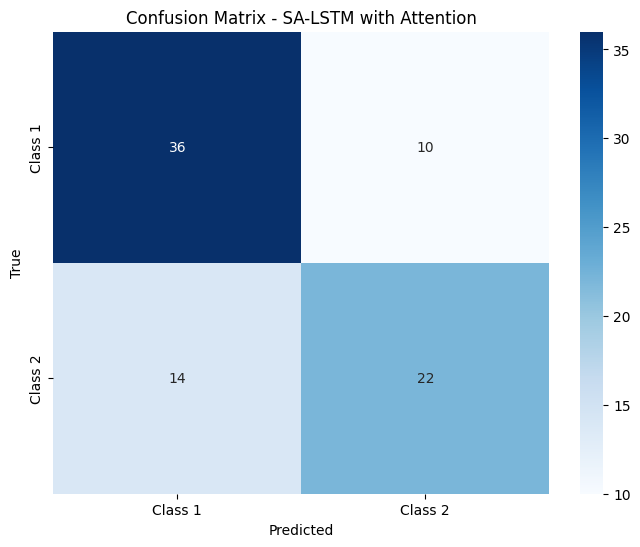

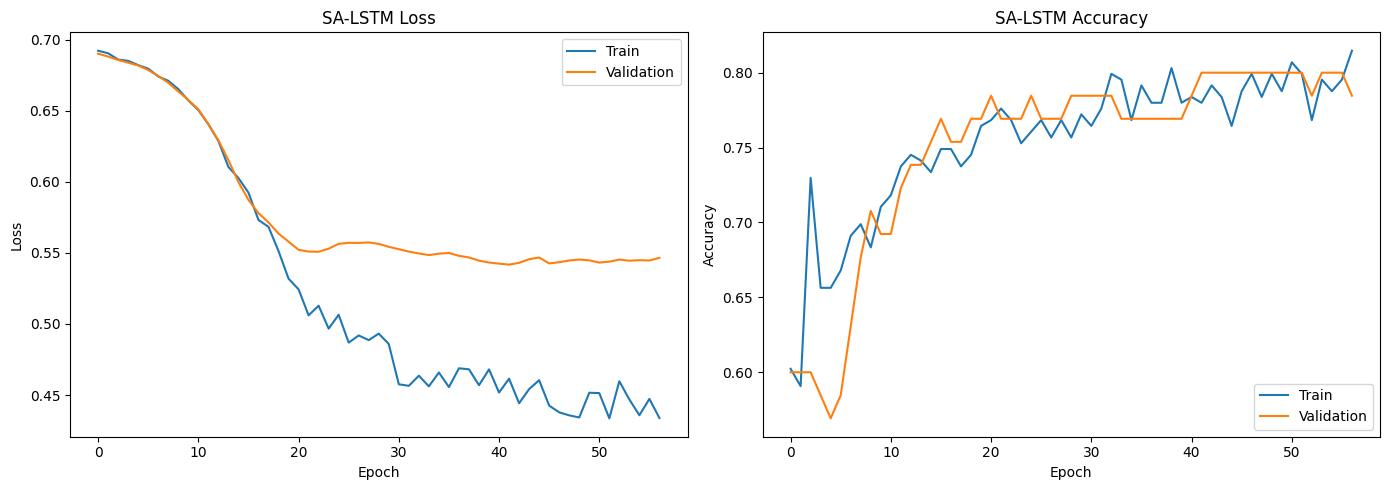

In [166]:

# Evaluate on test set
test_results = model.evaluate(X_test_lstm, y_test_lstm, verbose=1)
print(f"Test loss: {test_results[0]:.4f}")
print(f"Test accuracy: {test_results[1]:.4f}")
print(f"Test AUC: {test_results[2]:.4f}")
# Make predictions
y_pred_proba = model.predict(X_test_lstm, verbose=1)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()  # Flatten to ensure compatible shape
# Make predictions
# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nLSTM with Attention Classification Report:")
print(classification_report(y_test_lstm, y_pred))



# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test_lstm, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 1', 'Class 2'],
            yticklabels=['Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SA-LSTM with Attention')
plt.show()

# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('SA-LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('SA-LSTM Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

In [111]:
print(y_test_lstm)
print(y_pred)

[0 1 1 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0
 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0
 0 0 1 0 0 0 0 1]
[0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1
 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0]


# SSA-LSTM

In [140]:
# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.attention_weights = None

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Alignment scores. [batch_size, seq_len, 1]
        e = K.tanh(K.dot(x, self.W) + self.b)
        
        # Remove dimension of size 1. [batch_size, seq_len]
        e = K.squeeze(e, axis=-1)
        
        # Compute the weights. [batch_size, seq_len]
        alpha = K.softmax(e)
        
        # Reshape to [batch_size, seq_len, 1]
        alpha = K.expand_dims(alpha, axis=-1)
        
        # Compute the context vector. [batch_size, features]
        context = x * alpha
        context = K.sum(context, axis=1)
        
        return context 
    
class middleAttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(middleAttentionLayer, self).__init__(**kwargs)
        self.attention_weights = None

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(middleAttentionLayer, self).build(input_shape)

    def call(self, x):
        # Alignment scores. [batch_size, seq_len, 1]
        e = K.tanh(K.dot(x, self.W) + self.b)
        
        # # Remove dimension of size 1. [batch_size, seq_len]
        # e = K.squeeze(e, axis=-1)

        # # Compute the weights. [batch_size, seq_len]
        # alpha = K.softmax(e)
        
        # # Reshape to [batch_size, seq_len, 1]
        # alpha = K.expand_dims(alpha, axis=-1)
        
        self.attention_weights = K.softmax(e, axis=-1)

        # Compute the context vector. [batch_size, features]
        context = x * self.attention_weights
   
        return context  

def create_lstm_with_attention(input_shape, dropout_rate=0.2):
    """
    Create an LSTM model with Spatial Dropout and Attention for binary classification
    
    Args:
        input_shape: Tuple (timesteps, features) specifying input dimensions
        dropout_rate: Dropout rate to prevent overfitting
    
    Returns:
        Compiled Keras LSTM model with attention
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Spatial Dropout layer
    # This helps with overfitting by dropping entire feature maps
    x = BatchNormalization()(inputs)
    # print("x shape after BatchNormalization:", x.shape)  # Debugging line to check input shape
    # LSTM layer
    x = LSTM(24, return_sequences=True)(x)
    x = SpatialDropout1D(dropout_rate)(x)
    
    # Attention layer
    x = middleAttentionLayer()(x)

    x = LSTM(24, return_sequences=True)(x)
    x = SpatialDropout1D(dropout_rate)(x)
    x = AttentionLayer()(x)

    # Dropout for regularization
    x = Dropout(dropout_rate)(x)
 
    # Output layer
    outputs = Dense(1, activation='sigmoid')(x) 
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), 
                 tf.keras.metrics.Precision(), 
                 tf.keras.metrics.Recall()]
    )
    
    return model

In [169]:
# Assuming x1_train, y1_train, x1_test, y1_test are available from your notebook

# Prepare data 
# Option 1: Single timestep with all features
X_train_lstm, y_train_lstm, scaler = prepare_data_for_lstm(x1_train, y1_train)
# print("X_train_lstm shape:", X_train_lstm.shape)
X_test_lstm, y_test_lstm, _ = prepare_data_for_lstm(x1_test, y1_test)

# Option 2: Multiple timesteps (feature groups)
# X_train_lstm, y_train_lstm, scaler = prepare_sequence_data(x1_train, y1_train, n_steps=4)
# X_test_lstm, y_test_lstm, _ = prepare_sequence_data(x1_test, y1_test, n_steps=4)

# Create model
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])  # (timesteps, features)
# print("Input shape for LSTM with attention:", input_shape)
model = create_lstm_with_attention(input_shape)

# Model summary
model.summary()

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ModelCheckpoint('best_lstm_attention_model.h5', save_best_only=True, monitor='val_loss'),
    # Optionally add learning rate reduction callback
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001
    )
]

# Calculate class weights - important for imbalanced data
from sklearn.utils.class_weight import compute_class_weight
unique_classes = np.unique(y_train_lstm)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_lstm)
class_weight_dict = {i: weight for i, weight in zip(unique_classes, class_weights)}
print("Class weights:", class_weight_dict)

# Train model
history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)



Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1, 24)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1, 24)          │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 1, 24)          │         4,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_8             │ (None, 1, 24)          │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ middle_attention_layer_4        │ (None, 1, 24)          │            25 │
│ (middleAttentionLayer)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 1, 24)          │         4,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_9             │ (None, 1, 24)          │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_4               │ (None, 24)             │            25 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,579 (37.42 KB)

 Trainable params: 9,531 (37.23 KB)

 Non-trainable params: 48 (192.00 B)

Class weights: {np.int64(0): np.float64(0.8852459016393442), np.int64(1): np.float64(1.148936170212766)}
Epoch 1/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.5625 - auc_4: 0.5198 - loss: 0.7164 - precision_4: 0.6667 - recall_4: 0.4444

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.5284 - auc_4: 0.4834 - loss: 0.7006 - precision_4: 0.5055 - recall_4: 0.5178 - val_accuracy: 0.4923 - val_auc_4: 0.5730 - val_loss: 0.6917 - val_precision_4: 0.4054 - val_recall_4: 0.5769 - learning_rate: 0.0010
Epoch 2/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5312 - auc_4: 0.6373 - loss: 0.6928 - precision_4: 0.5000 - recall_4: 0.6000

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5643 - auc_4: 0.6284 - loss: 0.6879 - precision_4: 0.4936 - recall_4: 0.6665 - val_accuracy: 0.6154 - val_auc_4: 0.6642 - val_loss: 0.6890 - val_precision_4: 0.5143 - val_recall_4: 0.6923 - learning_rate: 0.0010
Epoch 3/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5312 - auc_4: 0.6385 - loss: 0.6744 - precision_4: 0.4000 - recall_4: 0.7273

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5821 - auc_4: 0.6709 - loss: 0.6884 - precision_4: 0.5178 - recall_4: 0.7366 - val_accuracy: 0.6154 - val_auc_4: 0.6958 - val_loss: 0.6868 - val_precision_4: 0.5143 - val_recall_4: 0.6923 - learning_rate: 0.0010
Epoch 4/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5312 - auc_4: 0.7083 - loss: 0.6417 - precision_4: 0.2632 - recall_4: 0.8333

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6104 - auc_4: 0.7159 - loss: 0.6757 - precision_4: 0.4999 - recall_4: 0.7863 - val_accuracy: 0.6769 - val_auc_4: 0.7342 - val_loss: 0.6833 - val_precision_4: 0.5806 - val_recall_4: 0.6923 - learning_rate: 0.0010
Epoch 5/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - auc_4: 0.8866 - loss: 0.6738 - precision_4: 0.6316 - recall_4: 0.9231

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7225 - auc_4: 0.7879 - loss: 0.6838 - precision_4: 0.6542 - recall_4: 0.8335 - val_accuracy: 0.7077 - val_auc_4: 0.7539 - val_loss: 0.6796 - val_precision_4: 0.6207 - val_recall_4: 0.6923 - learning_rate: 0.0010
Epoch 6/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6250 - auc_4: 0.7235 - loss: 0.6879 - precision_4: 0.5714 - recall_4: 0.8000

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6481 - auc_4: 0.7337 - loss: 0.6781 - precision_4: 0.5665 - recall_4: 0.7805 - val_accuracy: 0.6923 - val_auc_4: 0.7707 - val_loss: 0.6759 - val_precision_4: 0.6000 - val_recall_4: 0.6923 - learning_rate: 0.0010
Epoch 7/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6875 - auc_4: 0.7679 - loss: 0.6727 - precision_4: 0.6000 - recall_4: 0.8571

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6645 - auc_4: 0.7615 - loss: 0.6734 - precision_4: 0.5933 - recall_4: 0.7655 - val_accuracy: 0.7231 - val_auc_4: 0.7880 - val_loss: 0.6711 - val_precision_4: 0.6429 - val_recall_4: 0.6923 - learning_rate: 0.0010
Epoch 8/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6875 - auc_4: 0.7314 - loss: 0.6904 - precision_4: 0.6667 - recall_4: 0.8235

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6747 - auc_4: 0.7450 - loss: 0.6748 - precision_4: 0.6124 - recall_4: 0.7712 - val_accuracy: 0.7231 - val_auc_4: 0.7914 - val_loss: 0.6649 - val_precision_4: 0.6429 - val_recall_4: 0.6923 - learning_rate: 0.0010
Epoch 9/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6250 - auc_4: 0.7068 - loss: 0.6545 - precision_4: 0.4375 - recall_4: 0.7000

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6867 - auc_4: 0.7527 - loss: 0.6642 - precision_4: 0.6135 - recall_4: 0.6959 - val_accuracy: 0.7538 - val_auc_4: 0.7939 - val_loss: 0.6573 - val_precision_4: 0.6923 - val_recall_4: 0.6923 - learning_rate: 0.0010
Epoch 10/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6250 - auc_4: 0.6863 - loss: 0.6727 - precision_4: 0.6000 - recall_4: 0.6000

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6827 - auc_4: 0.7716 - loss: 0.6603 - precision_4: 0.6554 - recall_4: 0.6621 - val_accuracy: 0.7692 - val_auc_4: 0.8067 - val_loss: 0.6484 - val_precision_4: 0.7200 - val_recall_4: 0.6923 - learning_rate: 0.0010
Epoch 11/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7188 - auc_4: 0.7977 - loss: 0.6349 - precision_4: 0.5455 - recall_4: 0.6000

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7386 - auc_4: 0.8074 - loss: 0.6431 - precision_4: 0.6743 - recall_4: 0.6709 - val_accuracy: 0.7846 - val_auc_4: 0.8171 - val_loss: 0.6377 - val_precision_4: 0.7308 - val_recall_4: 0.7308 - learning_rate: 0.0010
Epoch 12/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7188 - auc_4: 0.8000 - loss: 0.6410 - precision_4: 0.7143 - recall_4: 0.6667

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7488 - auc_4: 0.8244 - loss: 0.6331 - precision_4: 0.7029 - recall_4: 0.7279 - val_accuracy: 0.7846 - val_auc_4: 0.8180 - val_loss: 0.6254 - val_precision_4: 0.7308 - val_recall_4: 0.7308 - learning_rate: 0.0010
Epoch 13/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8125 - auc_4: 0.9167 - loss: 0.5994 - precision_4: 0.7857 - recall_4: 0.7857

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7425 - auc_4: 0.8381 - loss: 0.6194 - precision_4: 0.7209 - recall_4: 0.7138 - val_accuracy: 0.7846 - val_auc_4: 0.8166 - val_loss: 0.6132 - val_precision_4: 0.7308 - val_recall_4: 0.7308 - learning_rate: 0.0010
Epoch 14/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5938 - auc_4: 0.6763 - loss: 0.6375 - precision_4: 0.3750 - recall_4: 0.6667

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7237 - auc_4: 0.8014 - loss: 0.6195 - precision_4: 0.6698 - recall_4: 0.7051 - val_accuracy: 0.7692 - val_auc_4: 0.8161 - val_loss: 0.6011 - val_precision_4: 0.7200 - val_recall_4: 0.6923 - learning_rate: 0.0010
Epoch 15/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7188 - auc_4: 0.8431 - loss: 0.6073 - precision_4: 0.7500 - recall_4: 0.7059

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7350 - auc_4: 0.8365 - loss: 0.6023 - precision_4: 0.7405 - recall_4: 0.6948 - val_accuracy: 0.7692 - val_auc_4: 0.8156 - val_loss: 0.5902 - val_precision_4: 0.7200 - val_recall_4: 0.6923 - learning_rate: 0.0010
Epoch 16/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7188 - auc_4: 0.7941 - loss: 0.5975 - precision_4: 0.7222 - recall_4: 0.7647

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7657 - auc_4: 0.8248 - loss: 0.5853 - precision_4: 0.7613 - recall_4: 0.7494 - val_accuracy: 0.7846 - val_auc_4: 0.8121 - val_loss: 0.5810 - val_precision_4: 0.7308 - val_recall_4: 0.7308 - learning_rate: 0.0010
Epoch 17/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7812 - auc_4: 0.8396 - loss: 0.5523 - precision_4: 0.6923 - recall_4: 0.7500

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7816 - auc_4: 0.8455 - loss: 0.5599 - precision_4: 0.7386 - recall_4: 0.7724 - val_accuracy: 0.7846 - val_auc_4: 0.8111 - val_loss: 0.5705 - val_precision_4: 0.7308 - val_recall_4: 0.7308 - learning_rate: 0.0010
Epoch 18/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - auc_4: 0.8792 - loss: 0.5136 - precision_4: 0.6429 - recall_4: 0.7500

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7504 - auc_4: 0.8392 - loss: 0.5483 - precision_4: 0.6997 - recall_4: 0.7581 - val_accuracy: 0.7846 - val_auc_4: 0.8087 - val_loss: 0.5648 - val_precision_4: 0.7308 - val_recall_4: 0.7308 - learning_rate: 0.0010
Epoch 19/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7812 - auc_4: 0.8136 - loss: 0.5397 - precision_4: 0.6154 - recall_4: 0.8000

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7823 - auc_4: 0.8469 - loss: 0.5339 - precision_4: 0.7227 - recall_4: 0.7777 - val_accuracy: 0.8000 - val_auc_4: 0.8067 - val_loss: 0.5562 - val_precision_4: 0.7600 - val_recall_4: 0.7308 - learning_rate: 0.0010
Epoch 20/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7812 - auc_4: 0.8725 - loss: 0.5194 - precision_4: 0.7857 - recall_4: 0.7333

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7485 - auc_4: 0.8424 - loss: 0.5291 - precision_4: 0.7296 - recall_4: 0.7096 - val_accuracy: 0.7846 - val_auc_4: 0.8087 - val_loss: 0.5513 - val_precision_4: 0.7308 - val_recall_4: 0.7308 - learning_rate: 0.0010
Epoch 21/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8438 - auc_4: 0.8571 - loss: 0.5030 - precision_4: 0.8000 - recall_4: 0.8571

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7699 - auc_4: 0.8352 - loss: 0.5215 - precision_4: 0.7386 - recall_4: 0.7427 - val_accuracy: 0.7846 - val_auc_4: 0.8072 - val_loss: 0.5482 - val_precision_4: 0.7308 - val_recall_4: 0.7308 - learning_rate: 0.0010
Epoch 22/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7812 - auc_4: 0.8360 - loss: 0.5643 - precision_4: 0.8333 - recall_4: 0.7895

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7644 - auc_4: 0.8479 - loss: 0.5135 - precision_4: 0.7613 - recall_4: 0.7387 - val_accuracy: 0.7846 - val_auc_4: 0.8077 - val_loss: 0.5456 - val_precision_4: 0.7308 - val_recall_4: 0.7308 - learning_rate: 0.0010
Epoch 23/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7188 - auc_4: 0.8360 - loss: 0.5124 - precision_4: 0.6250 - recall_4: 0.7692

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7506 - auc_4: 0.8512 - loss: 0.4983 - precision_4: 0.7236 - recall_4: 0.7333 - val_accuracy: 0.8000 - val_auc_4: 0.8067 - val_loss: 0.5420 - val_precision_4: 0.7600 - val_recall_4: 0.7308 - learning_rate: 0.0010
Epoch 24/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - auc_4: 0.8255 - loss: 0.4823 - precision_4: 0.7692 - recall_4: 0.6667

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7791 - auc_4: 0.8448 - loss: 0.4920 - precision_4: 0.7524 - recall_4: 0.7479 - val_accuracy: 0.7846 - val_auc_4: 0.8097 - val_loss: 0.5401 - val_precision_4: 0.7308 - val_recall_4: 0.7308 - learning_rate: 0.0010
Epoch 25/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7188 - auc_4: 0.8000 - loss: 0.5474 - precision_4: 0.6154 - recall_4: 0.6667

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7520 - auc_4: 0.8403 - loss: 0.4959 - precision_4: 0.7006 - recall_4: 0.7347 - val_accuracy: 0.7846 - val_auc_4: 0.8121 - val_loss: 0.5356 - val_precision_4: 0.7308 - val_recall_4: 0.7308 - learning_rate: 0.0010
Epoch 26/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7349 - auc_4: 0.8406 - loss: 0.4972 - precision_4: 0.7114 - recall_4: 0.7002 - val_accuracy: 0.8000 - val_auc_4: 0.8136 - val_loss: 0.5359 - val_precision_4: 0.7600 - val_recall_4: 0.7308 - learning_rate: 0.0010
Epoch 27/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7500 - auc_4: 0.8440 - loss: 0.4832 - precision_4: 0.7191 - recall_4: 0.7213 - val_accuracy: 0.8000 - val_auc_4: 0.8146 - val_loss: 0.5359 - val_precision_4: 0.7600 - val_recall_4: 0.7308 - learning_rate: 0.0010
Epoch 28/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7610 - auc_4: 0.8401 - loss: 0.4950 - precision_4: 0.7302 - recall_4: 0.7290 - val_accuracy: 0.8000 - val_auc_4: 0.81

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7570 - auc_4: 0.8632 - loss: 0.4729 - precision_4: 0.7540 - recall_4: 0.7117 - val_accuracy: 0.8154 - val_auc_4: 0.8156 - val_loss: 0.5341 - val_precision_4: 0.7917 - val_recall_4: 0.7308 - learning_rate: 0.0010
Epoch 31/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7188 - auc_4: 0.8353 - loss: 0.4994 - precision_4: 0.6923 - recall_4: 0.6429

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7694 - auc_4: 0.8591 - loss: 0.4653 - precision_4: 0.7653 - recall_4: 0.7058 - val_accuracy: 0.8000 - val_auc_4: 0.8171 - val_loss: 0.5317 - val_precision_4: 0.7826 - val_recall_4: 0.6923 - learning_rate: 0.0010
Epoch 32/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7433 - auc_4: 0.8529 - loss: 0.4599 - precision_4: 0.6984 - recall_4: 0.6931 - val_accuracy: 0.8000 - val_auc_4: 0.8205 - val_loss: 0.5333 - val_precision_4: 0.7826 - val_recall_4: 0.6923 - learning_rate: 0.0010
Epoch 33/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7702 - auc_4: 0.8477 - loss: 0.4869 - precision_4: 0.7519 - recall_4: 0.7300 - val_accuracy: 0.8000 - val_auc_4: 0.8151 - val_loss: 0.5356 - val_precision_4: 0.7826 - val_recall_4: 0.6923 - learning_rate: 0.0010
Epoch 34/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8078 - auc_4: 0.8840 - loss: 0.4403 - precision_4: 0.8335 - recall_4: 0.7645 - val_accuracy: 0.8000 - val_auc_4: 0.81

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7726 - auc_4: 0.7975 - loss: 0.5444 - precision_4: 0.7762 - recall_4: 0.6838
Test loss: 0.5484
Test accuracy: 0.7561
Test AUC: 0.7766
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

LSTM with Attention Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.87      0.80        46
           1       0.79      0.61      0.69        36

    accuracy                           0.76        82
   macro avg       0.76      0.74      0.74        82
weighted avg       0.76      0.76      0.75        82



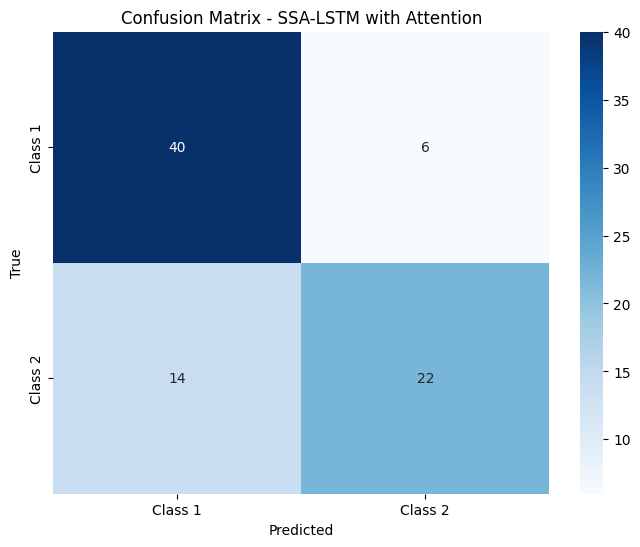

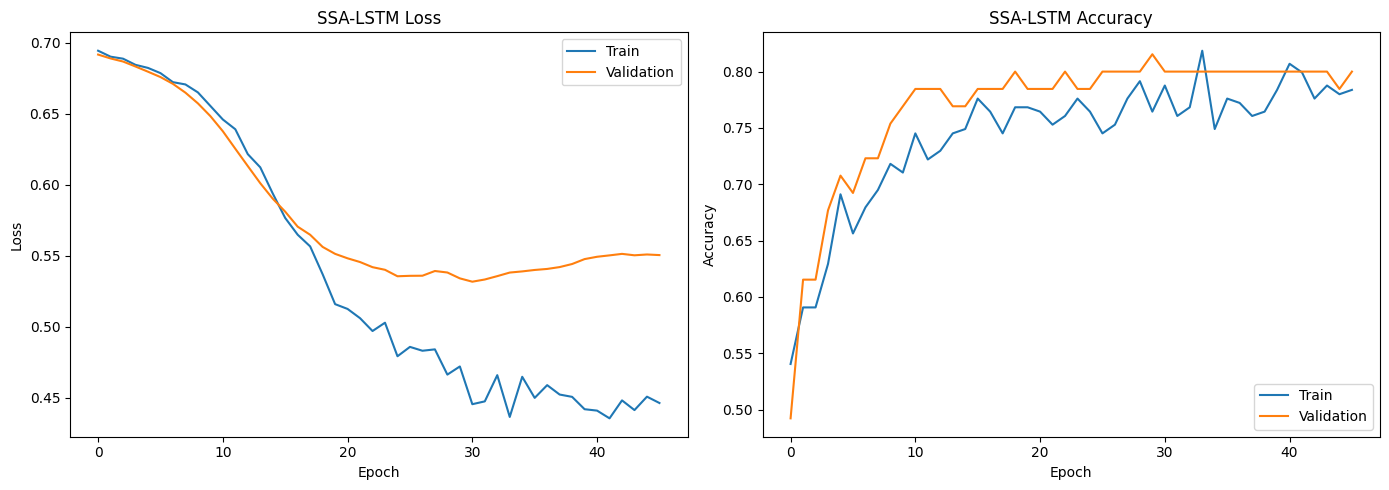

In [170]:
# Evaluate on test set
test_results = model.evaluate(X_test_lstm, y_test_lstm, verbose=1)
print(f"Test loss: {test_results[0]:.4f}")
print(f"Test accuracy: {test_results[1]:.4f}")
print(f"Test AUC: {test_results[2]:.4f}")
# Make predictions
y_pred_proba = model.predict(X_test_lstm, verbose=1)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()  # Flatten to ensure compatible shape
# Make predictions
# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nLSTM with Attention Classification Report:")
print(classification_report(y_test_lstm, y_pred))



# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test_lstm, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 1', 'Class 2'],
            yticklabels=['Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SSA-LSTM with Attention')
plt.show()

# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('SSA-LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('SSA-LSTM Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

In [143]:
print(y_test_lstm)
print(y_pred)

[0 1 1 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0
 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0
 0 0 1 0 0 0 0 1]
[0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 1
 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0]


In [248]:
# Example input: (1 sample, 1 time steps, 24 features)
example_input = np.random.rand(1, 1, 24).astype(np.float32)

middle_attention_layer_3 = Model(inputs=model.input,
                        outputs=model.get_layer('middle_attention_layer_4').output)


middle_attention_layer_3_output = middle_attention_layer_3.predict(example_input)

middle_attention_layer_3_feature_attention = middle_attention_layer_3_output.mean(axis=1)  # (1, 24)
print("Average middle_attention_layer_3 Feature Attention:", middle_attention_layer_3_feature_attention)

# sorted_indices_middle_layer = np.argsort(middle_attention_layer_3_feature_attention)[::-1]  # Sort indices in descending order
# sorted_names_middle_layer = x1_features.to_numpy()[sorted_indices_middle_layer]
# sorted_scores_middle_layer = middle_attention_layer_3_feature_attention[0][sorted_indices_middle_layer]
# print('asda',sorted_names_middle_layer)

# ATTENTION LAYER 44
attention_layer_44 = Model(inputs=model.input,
                        outputs=model.get_layer('attention_layer_4').output)


attention_layer_44_output = attention_layer_44.predict(example_input)
# sorted_indices_last_layer = np.argsort(attention_layer_44_output)[::-1]  # Sort indices in descending order
# sorted_names_last_layer = x1_features.to_numpy()[sorted_indices_last_layer]
# sorted_scores_last_layer = attention_layer_44_output[0][sorted_indices_last_layer]

print("Average Feature Attention:", attention_layer_44_output)


plt.bar(range(24), attention_layer_44_output[0], color='red', alpha=0.6, label ='Last Attention Layer')
plt.bar(range(24), middle_attention_layer_3_feature_attention[0], color='blue', alpha=0.6, label ='Middle Attention Layer')
plt.xticks(range(24), [x1_features[i] for i in range(24)], rotation=90)
plt.title("SSA-LSTM 0.76 Feature Attention Importance")
plt.ylabel("Attention Weight")
plt.xlabel("Feature")
plt.legend()
plt.ylim(-0.5, 0.5)

plt.show()

ValueError: No such layer: middle_attention_layer_4. Existing layers are: ['input_layer_7', 'batch_normalization_7', 'lstm_14', 'spatial_dropout1d_14', 'middle_attention_layer_7', 'lstm_15', 'spatial_dropout1d_15', 'attention_layer_7', 'dropout_7', 'dense_7'].

# + BLOOD INDEX

In [86]:
count = 0
for i in range(len(df_set['Day of illness'])):
    if df_set['Day of illness'][i] == 0:
        count += 1  

print("Number of samples with 'Day of illness' = 0:", count)

Number of samples with 'Day of illness' = 0: 0


In [85]:
# df_set = df_set.to_numpy()
df_set.reset_index(drop=True, inplace=True)
print(df_set.shape)
# df_set.loc[200, 'Day of illness']


(403, 21)


In [90]:
day_array = []
indx = ['WBC','N','L','RBC','Hb','HCT','PLT','MPV ']
for i in range(df_set.shape[0]):
    day = df_set.loc[i, 'Day of illness']
    for j in range(len(indx)):
        df_col = indx[j] + str(day)
        day_array.append(df.loc[i, df_col])

print(len(day_array)/8)

new_col = np.array(day_array).reshape(-1, 8)

new_arr = np.hstack((df_set.to_numpy(), new_col))

print(new_arr)

403.0
[['1' '0' '1' ... 'nan' 'nan' 'nan']
 ['1' '0' '1' ... '0,421' '125' '9']
 ['0' '0' '0' ... 'nan' 'nan' 'nan']
 ...
 ['1' '0' '0' ... '0,380' '37' '9,8']
 ['1' '0' '1' ... '0,380' '27' '10,2']
 ['1' '0' '0' ... 'nan' 'nan' 'nan']]


## blood indexes 2.0

In [304]:
df_bl = df.loc[:, 'WBC1':'MPV 9'].copy()
# df_bl = df_bl.apply(pd.to_numeric, errors='coerce')


df_bl = df_bl.drop(['MPV 1','MPV 2','MPV 3','MPV 4', 'MPV 5', 'MPV 6', 'MPV 7', 'MPV 8', 'MPV 9'], axis=1)
df_bl = df_bl.replace('(17/9)3.7', 3.7)
df_bl = df_bl.replace('(28/6)4.1', 4.1)
df_bl = df_bl.replace('(27/11)5.5', 5.5)
df_bl = df_bl.replace(' ', np.nan)
x1_features = df_bl.columns
for i in df_bl.columns:
    df_bl[i] = df_bl[i].str.replace(',', '.', regex=False).astype(float)
df_bl.reset_index(drop=True, inplace=True) #reset index
df_bl.fillna(0, inplace=True) #fill NaN with 0
df_bl = df_bl.to_numpy()

print(df_bl.shape)


(406, 63)


In [227]:
df_bl

array([[  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       ...,
       [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  , ..., 130.  ,   0.38,  18.  ],
       [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]])

In [228]:
print(df_bl[1][0:16])
print(df_bl[1][df_bl[1] != 0])

[  0.      0.      0.      0.      0.      0.      0.      7.3    80.97
   6.29    4.5   142.      0.421 125.      0.      0.   ]
[  7.3    80.97    6.29    4.5   142.      0.421 125.      1.77   53.1
  35.      4.82  146.      0.437  71.   ]


In [229]:
bl_list = []
bl_arr = []
for i in range(df_bl.shape[0]):
    # Extract non-zero elements
    non_zero_elements = df_bl[i][np.nonzero(df_bl[i])]
    bl_list.append(non_zero_elements)
    bl_arr.append(bl_list[i][:7])


bl_arr = np.array(bl_arr)
print(bl_arr.shape)

(406, 7)


In [230]:
bl_arr

array([[  5.16 ,  67.99 ,  18.01 , ..., 160.   ,   0.49 , 136.   ],
       [  7.3  ,  80.97 ,   6.29 , ..., 142.   ,   0.421, 125.   ],
       [  2.4  ,  67.97 ,  21.83 , ..., 128.   ,   0.37 ,  79.   ],
       ...,
       [  1.6  ,  37.   ,  50.   , ..., 147.   ,   0.47 ,  65.   ],
       [  5.9  ,  26.   ,  64.   , ..., 158.   ,   0.44 ,   7.   ],
       [  3.21 ,  43.9  ,  48.   , ..., 166.   ,   0.47 ,  12.   ]])

In [276]:
x1_train, x1_test, y1_train, y1_test = train_test_split(bl_arr, df['Diagnosis'], \
                                                    test_size=0.2, random_state=17, stratify=df['Diagnosis'])


print('x1_train shape: ', x1_train.shape, 'y1_train shape: ',  y1_train.shape)
print('x1_test shape: ', x1_test.shape, 'y1_test shape: ',  y1_test.shape)
uniques, counts = np.unique(y1_test, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y1_test), 2))))

x1_train shape:  (324, 7) y1_train shape:  (324,)
x1_test shape:  (82, 7) y1_test shape:  (82,)
percentage of classes:  {'1': np.float64(56.1), '2': np.float64(43.9)}


In [277]:
# x1_train = x1_train.to_numpy()
y1_train = y1_train.to_numpy()
# x1_test = x1_test.to_numpy()
y1_test = y1_test.to_numpy()

x1_train = x1_train.astype(np.float64)
y1_train = y1_train.astype(np.int64)
x1_test = x1_test.astype(np.float64)
y1_test = y1_test.astype(np.int64)

y1_train = y1_train - 1
y1_test = y1_test - 1

In [233]:
x1_train

array([[  4.66 ,  76.   ,  12.9  , ..., 131.   ,   0.377, 316.   ],
       [  3.95 ,  41.3  ,  39.2  , ..., 129.   ,   0.402, 179.   ],
       [  2.63 ,  45.5  ,  46.8  , ..., 141.   ,   0.423,  45.   ],
       ...,
       [  2.2  ,  47.8  ,  41.7  , ..., 149.   ,   0.434,  51.   ],
       [  6.1  ,  81.   ,   8.9  , ..., 132.   ,   0.37 , 137.   ],
       [ 11.4  ,  74.   ,   6.4  , ..., 141.   ,   0.43 , 161.   ]])

In [279]:
# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.attention_weights = None

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Alignment scores. [batch_size, seq_len, 1]
        e = K.tanh(K.dot(x, self.W) + self.b)
        
        # Remove dimension of size 1. [batch_size, seq_len]
        e = K.squeeze(e, axis=-1)
        
        # Compute the weights. [batch_size, seq_len]
        alpha = K.softmax(e)
        
        # Reshape to [batch_size, seq_len, 1]
        alpha = K.expand_dims(alpha, axis=-1)
        
        # Compute the context vector. [batch_size, features]
        context = x * alpha
        context = K.sum(context, axis=1)
        
        return context 
    
class middleAttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(middleAttentionLayer, self).__init__(**kwargs)
        self.attention_weights = None

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(middleAttentionLayer, self).build(input_shape)

    def call(self, x):
        # Alignment scores. [batch_size, seq_len, 1]
        e = K.tanh(K.dot(x, self.W) + self.b)
        
        # # Remove dimension of size 1. [batch_size, seq_len]
        # e = K.squeeze(e, axis=-1)

        # # Compute the weights. [batch_size, seq_len]
        # alpha = K.softmax(e)
        
        # # Reshape to [batch_size, seq_len, 1]
        # alpha = K.expand_dims(alpha, axis=-1)
        
        self.attention_weights = K.softmax(e, axis=-1)

        # Compute the context vector. [batch_size, features]
        context = x * self.attention_weights
   
        return context  

def create_lstm_with_attention(input_shape, dropout_rate=0.2):
    """
    Create an LSTM model with Spatial Dropout and Attention for binary classification
    
    Args:
        input_shape: Tuple (timesteps, features) specifying input dimensions
        dropout_rate: Dropout rate to prevent overfitting
    
    Returns:
        Compiled Keras LSTM model with attention
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Spatial Dropout layer
    # This helps with overfitting by dropping entire feature maps
    x = BatchNormalization()(inputs)
    # print("x shape after BatchNormalization:", x.shape)  # Debugging line to check input shape
    # LSTM layer
    x = LSTM(7, return_sequences=True)(x)
    x = SpatialDropout1D(dropout_rate)(x)
    
    # Attention layer
    x = middleAttentionLayer()(x)

    x = LSTM(7, return_sequences=True)(x)
    x = SpatialDropout1D(dropout_rate)(x)
    x = AttentionLayer()(x)

    # Dropout for regularization
    x = Dropout(dropout_rate)(x)
 
    # Output layer
    outputs = Dense(1, activation='sigmoid')(x) 
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), 
                 tf.keras.metrics.Precision(), 
                 tf.keras.metrics.Recall()]
    )
    
    return model

In [280]:
# Assuming x1_train, y1_train, x1_test, y1_test are available from your notebook

# Prepare data 
# Option 1: Single timestep with all features
X_train_lstm, y_train_lstm, scaler = prepare_data_for_lstm(x1_train, y1_train)
# print("X_train_lstm shape:", X_train_lstm.shape)
X_test_lstm, y_test_lstm, _ = prepare_data_for_lstm(x1_test, y1_test)

# Option 2: Multiple timesteps (feature groups)
# X_train_lstm, y_train_lstm, scaler = prepare_sequence_data(x1_train, y1_train, n_steps=4)
# X_test_lstm, y_test_lstm, _ = prepare_sequence_data(x1_test, y1_test, n_steps=4)

# Create model
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])  # (timesteps, features)
# print("Input shape for LSTM with attention:", input_shape)
model = create_lstm_with_attention(input_shape)

# Model summary
model.summary()

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ModelCheckpoint('best_lstm_attention_model.h5', save_best_only=True, monitor='val_loss'),
    # Optionally add learning rate reduction callback
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001
    )
]

# Calculate class weights - important for imbalanced data
from sklearn.utils.class_weight import compute_class_weight
unique_classes = np.unique(y_train_lstm)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_lstm)
class_weight_dict = {i: weight for i, weight in zip(unique_classes, class_weights)}
print("Class weights:", class_weight_dict)

# Train model
history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)



Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 1, 7)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1, 7)           │            28 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 1, 7)           │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_20            │ (None, 1, 7)           │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ middle_attention_layer_10       │ (None, 1, 7)           │             8 │
│ (middleAttentionLayer)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 1, 7)           │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_21            │ (None, 1, 7)           │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_10              │ (None, 7)              │             8 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 892 (3.48 KB)

 Trainable params: 878 (3.43 KB)

 Non-trainable params: 14 (56.00 B)

Class weights: {np.int64(0): np.float64(0.8852459016393442), np.int64(1): np.float64(1.148936170212766)}
Epoch 1/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.5000 - auc_10: 0.4647 - loss: 0.6993 - precision_10: 0.4667 - recall_10: 0.4667

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.5043 - auc_10: 0.5100 - loss: 0.6961 - precision_10: 0.4632 - recall_10: 0.5257 - val_accuracy: 0.5538 - val_auc_10: 0.5863 - val_loss: 0.6921 - val_precision_10: 0.4615 - val_recall_10: 0.6923 - learning_rate: 0.0010
Epoch 2/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5000 - auc_10: 0.5139 - loss: 0.6932 - precision_10: 0.4500 - recall_10: 0.6429

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4891 - auc_10: 0.5454 - loss: 0.6935 - precision_10: 0.4430 - recall_10: 0.5915 - val_accuracy: 0.5077 - val_auc_10: 0.5858 - val_loss: 0.6917 - val_precision_10: 0.4318 - val_recall_10: 0.7308 - learning_rate: 0.0010
Epoch 3/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5625 - auc_10: 0.6083 - loss: 0.7215 - precision_10: 0.6667 - recall_10: 0.6000

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5048 - auc_10: 0.5638 - loss: 0.7005 - precision_10: 0.4967 - recall_10: 0.6448 - val_accuracy: 0.5385 - val_auc_10: 0.6548 - val_loss: 0.6911 - val_precision_10: 0.4500 - val_recall_10: 0.6923 - learning_rate: 0.0010
Epoch 4/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5312 - auc_10: 0.5529 - loss: 0.6975 - precision_10: 0.5000 - recall_10: 0.5333

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5182 - auc_10: 0.5528 - loss: 0.6953 - precision_10: 0.4794 - recall_10: 0.5548 - val_accuracy: 0.5231 - val_auc_10: 0.6420 - val_loss: 0.6905 - val_precision_10: 0.4324 - val_recall_10: 0.6154 - learning_rate: 0.0010
Epoch 5/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6562 - auc_10: 0.6250 - loss: 0.6908 - precision_10: 0.5882 - recall_10: 0.7143

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5948 - auc_10: 0.6194 - loss: 0.6917 - precision_10: 0.5397 - recall_10: 0.6599 - val_accuracy: 0.5077 - val_auc_10: 0.6410 - val_loss: 0.6899 - val_precision_10: 0.4167 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 6/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6250 - auc_10: 0.6958 - loss: 0.6759 - precision_10: 0.5000 - recall_10: 0.5833

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5881 - auc_10: 0.6605 - loss: 0.6844 - precision_10: 0.5031 - recall_10: 0.6137 - val_accuracy: 0.5538 - val_auc_10: 0.6455 - val_loss: 0.6893 - val_precision_10: 0.4545 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 7/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5938 - auc_10: 0.6012 - loss: 0.6836 - precision_10: 0.5000 - recall_10: 0.5385

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6332 - auc_10: 0.6454 - loss: 0.6854 - precision_10: 0.5596 - recall_10: 0.6389 - val_accuracy: 0.5692 - val_auc_10: 0.6297 - val_loss: 0.6886 - val_precision_10: 0.4688 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 8/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - auc_10: 0.7560 - loss: 0.6847 - precision_10: 0.6875 - recall_10: 0.7857

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6590 - auc_10: 0.6794 - loss: 0.6895 - precision_10: 0.6121 - recall_10: 0.6797 - val_accuracy: 0.5385 - val_auc_10: 0.6548 - val_loss: 0.6883 - val_precision_10: 0.4444 - val_recall_10: 0.6154 - learning_rate: 0.0010
Epoch 9/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5625 - auc_10: 0.5933 - loss: 0.7110 - precision_10: 0.6111 - recall_10: 0.6111

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5709 - auc_10: 0.6264 - loss: 0.6926 - precision_10: 0.5329 - recall_10: 0.6246 - val_accuracy: 0.5385 - val_auc_10: 0.6563 - val_loss: 0.6882 - val_precision_10: 0.4474 - val_recall_10: 0.6538 - learning_rate: 0.0010
Epoch 10/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6875 - auc_10: 0.7348 - loss: 0.6807 - precision_10: 0.5789 - recall_10: 0.8462

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6373 - auc_10: 0.6725 - loss: 0.6876 - precision_10: 0.5761 - recall_10: 0.6987 - val_accuracy: 0.5385 - val_auc_10: 0.6410 - val_loss: 0.6875 - val_precision_10: 0.4474 - val_recall_10: 0.6538 - learning_rate: 0.0010
Epoch 11/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6250 - auc_10: 0.7065 - loss: 0.6801 - precision_10: 0.5263 - recall_10: 0.7692

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6653 - auc_10: 0.6884 - loss: 0.6849 - precision_10: 0.5907 - recall_10: 0.7511 - val_accuracy: 0.5538 - val_auc_10: 0.6553 - val_loss: 0.6865 - val_precision_10: 0.4571 - val_recall_10: 0.6154 - learning_rate: 0.0010
Epoch 12/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8750 - auc_10: 0.8704 - loss: 0.6662 - precision_10: 0.7647 - recall_10: 1.0000

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7075 - auc_10: 0.7571 - loss: 0.6751 - precision_10: 0.6171 - recall_10: 0.8201 - val_accuracy: 0.5385 - val_auc_10: 0.6632 - val_loss: 0.6863 - val_precision_10: 0.4474 - val_recall_10: 0.6538 - learning_rate: 0.0010
Epoch 13/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6562 - auc_10: 0.7333 - loss: 0.6806 - precision_10: 0.6111 - recall_10: 0.7333

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5974 - auc_10: 0.6588 - loss: 0.6841 - precision_10: 0.5361 - recall_10: 0.6637 - val_accuracy: 0.5692 - val_auc_10: 0.6627 - val_loss: 0.6854 - val_precision_10: 0.4722 - val_recall_10: 0.6538 - learning_rate: 0.0010
Epoch 14/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6875 - auc_10: 0.6289 - loss: 0.6917 - precision_10: 0.6875 - recall_10: 0.6875

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6579 - auc_10: 0.6781 - loss: 0.6870 - precision_10: 0.6311 - recall_10: 0.6791 - val_accuracy: 0.5846 - val_auc_10: 0.6627 - val_loss: 0.6844 - val_precision_10: 0.4857 - val_recall_10: 0.6538 - learning_rate: 0.0010
Epoch 15/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6875 - auc_10: 0.7540 - loss: 0.6712 - precision_10: 0.6250 - recall_10: 0.7143

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6270 - auc_10: 0.6657 - loss: 0.6813 - precision_10: 0.5680 - recall_10: 0.6713 - val_accuracy: 0.5692 - val_auc_10: 0.6568 - val_loss: 0.6831 - val_precision_10: 0.4688 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 16/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5000 - auc_10: 0.5445 - loss: 0.7211 - precision_10: 0.6000 - recall_10: 0.4737

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6234 - auc_10: 0.6644 - loss: 0.6851 - precision_10: 0.5932 - recall_10: 0.6076 - val_accuracy: 0.5692 - val_auc_10: 0.6543 - val_loss: 0.6821 - val_precision_10: 0.4688 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 17/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6562 - auc_10: 0.6510 - loss: 0.6853 - precision_10: 0.6250 - recall_10: 0.6667

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6346 - auc_10: 0.6808 - loss: 0.6794 - precision_10: 0.5726 - recall_10: 0.6734 - val_accuracy: 0.5692 - val_auc_10: 0.6553 - val_loss: 0.6816 - val_precision_10: 0.4688 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 18/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6250 - auc_10: 0.6562 - loss: 0.6874 - precision_10: 0.6250 - recall_10: 0.6250

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6347 - auc_10: 0.6805 - loss: 0.6809 - precision_10: 0.6027 - recall_10: 0.6466 - val_accuracy: 0.5538 - val_auc_10: 0.6637 - val_loss: 0.6806 - val_precision_10: 0.4545 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 19/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6250 - auc_10: 0.7176 - loss: 0.6742 - precision_10: 0.6000 - recall_10: 0.6000

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6254 - auc_10: 0.6979 - loss: 0.6736 - precision_10: 0.5761 - recall_10: 0.6398 - val_accuracy: 0.5692 - val_auc_10: 0.6583 - val_loss: 0.6792 - val_precision_10: 0.4688 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 20/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6250 - auc_10: 0.6646 - loss: 0.7077 - precision_10: 0.7500 - recall_10: 0.6000

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6611 - auc_10: 0.6989 - loss: 0.6769 - precision_10: 0.6381 - recall_10: 0.6568 - val_accuracy: 0.5692 - val_auc_10: 0.6529 - val_loss: 0.6775 - val_precision_10: 0.4688 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 21/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6562 - auc_10: 0.7126 - loss: 0.6613 - precision_10: 0.5625 - recall_10: 0.6923

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6371 - auc_10: 0.6987 - loss: 0.6693 - precision_10: 0.5802 - recall_10: 0.6327 - val_accuracy: 0.5692 - val_auc_10: 0.6563 - val_loss: 0.6763 - val_precision_10: 0.4688 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 22/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6562 - auc_10: 0.7403 - loss: 0.6470 - precision_10: 0.5000 - recall_10: 0.7273

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6483 - auc_10: 0.6788 - loss: 0.6665 - precision_10: 0.5668 - recall_10: 0.6701 - val_accuracy: 0.5692 - val_auc_10: 0.6494 - val_loss: 0.6753 - val_precision_10: 0.4688 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 23/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6562 - auc_10: 0.6914 - loss: 0.6780 - precision_10: 0.6471 - recall_10: 0.6875

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6341 - auc_10: 0.6649 - loss: 0.6717 - precision_10: 0.5812 - recall_10: 0.6678 - val_accuracy: 0.5692 - val_auc_10: 0.6519 - val_loss: 0.6750 - val_precision_10: 0.4688 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 24/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6562 - auc_10: 0.6537 - loss: 0.7195 - precision_10: 0.8125 - recall_10: 0.6190

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6531 - auc_10: 0.6677 - loss: 0.6815 - precision_10: 0.6476 - recall_10: 0.6611 - val_accuracy: 0.5538 - val_auc_10: 0.6563 - val_loss: 0.6743 - val_precision_10: 0.4545 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 25/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6875 - auc_10: 0.6738 - loss: 0.6827 - precision_10: 0.6500 - recall_10: 0.8125

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6666 - auc_10: 0.6918 - loss: 0.6657 - precision_10: 0.6066 - recall_10: 0.7331 - val_accuracy: 0.5692 - val_auc_10: 0.6499 - val_loss: 0.6730 - val_precision_10: 0.4688 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 26/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6562 - auc_10: 0.7004 - loss: 0.6612 - precision_10: 0.5882 - recall_10: 0.7143

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6469 - auc_10: 0.6883 - loss: 0.6598 - precision_10: 0.5719 - recall_10: 0.7236 - val_accuracy: 0.5538 - val_auc_10: 0.6479 - val_loss: 0.6722 - val_precision_10: 0.4545 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 27/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5938 - auc_10: 0.6729 - loss: 0.6587 - precision_10: 0.4737 - recall_10: 0.7500

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6291 - auc_10: 0.6828 - loss: 0.6627 - precision_10: 0.5749 - recall_10: 0.6985 - val_accuracy: 0.5538 - val_auc_10: 0.6464 - val_loss: 0.6714 - val_precision_10: 0.4545 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 28/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5938 - auc_10: 0.6111 - loss: 0.6732 - precision_10: 0.5294 - recall_10: 0.6429

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6326 - auc_10: 0.6625 - loss: 0.6664 - precision_10: 0.5702 - recall_10: 0.6868 - val_accuracy: 0.5538 - val_auc_10: 0.6489 - val_loss: 0.6701 - val_precision_10: 0.4545 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 29/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6875 - auc_10: 0.8314 - loss: 0.6311 - precision_10: 0.6667 - recall_10: 0.6667

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6666 - auc_10: 0.7397 - loss: 0.6429 - precision_10: 0.6081 - recall_10: 0.6806 - val_accuracy: 0.5538 - val_auc_10: 0.6469 - val_loss: 0.6693 - val_precision_10: 0.4545 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 30/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6562 - auc_10: 0.8062 - loss: 0.6160 - precision_10: 0.5263 - recall_10: 0.8333

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6340 - auc_10: 0.6920 - loss: 0.6555 - precision_10: 0.5571 - recall_10: 0.7188 - val_accuracy: 0.5538 - val_auc_10: 0.6504 - val_loss: 0.6677 - val_precision_10: 0.4545 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 31/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6562 - auc_10: 0.6299 - loss: 0.6558 - precision_10: 0.5000 - recall_10: 0.6364

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6646 - auc_10: 0.7020 - loss: 0.6469 - precision_10: 0.5817 - recall_10: 0.7135 - val_accuracy: 0.5385 - val_auc_10: 0.6499 - val_loss: 0.6666 - val_precision_10: 0.4375 - val_recall_10: 0.5385 - learning_rate: 0.0010
Epoch 32/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6250 - auc_10: 0.6137 - loss: 0.6888 - precision_10: 0.6471 - recall_10: 0.6471

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6438 - auc_10: 0.6689 - loss: 0.6620 - precision_10: 0.6125 - recall_10: 0.6693 - val_accuracy: 0.5538 - val_auc_10: 0.6489 - val_loss: 0.6659 - val_precision_10: 0.4516 - val_recall_10: 0.5385 - learning_rate: 0.0010
Epoch 33/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5625 - auc_10: 0.5893 - loss: 0.6726 - precision_10: 0.5000 - recall_10: 0.6429

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6112 - auc_10: 0.6589 - loss: 0.6587 - precision_10: 0.5632 - recall_10: 0.6491 - val_accuracy: 0.5538 - val_auc_10: 0.6494 - val_loss: 0.6645 - val_precision_10: 0.4516 - val_recall_10: 0.5385 - learning_rate: 0.0010
Epoch 34/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6875 - auc_10: 0.7667 - loss: 0.6364 - precision_10: 0.5625 - recall_10: 0.7500

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6417 - auc_10: 0.6888 - loss: 0.6553 - precision_10: 0.5848 - recall_10: 0.6665 - val_accuracy: 0.5538 - val_auc_10: 0.6494 - val_loss: 0.6639 - val_precision_10: 0.4516 - val_recall_10: 0.5385 - learning_rate: 0.0010
Epoch 35/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6875 - auc_10: 0.7123 - loss: 0.6353 - precision_10: 0.6250 - recall_10: 0.7143

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6639 - auc_10: 0.6879 - loss: 0.6443 - precision_10: 0.5980 - recall_10: 0.6855 - val_accuracy: 0.5538 - val_auc_10: 0.6494 - val_loss: 0.6628 - val_precision_10: 0.4516 - val_recall_10: 0.5385 - learning_rate: 0.0010
Epoch 36/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6250 - auc_10: 0.6457 - loss: 0.6581 - precision_10: 0.5333 - recall_10: 0.6154

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6868 - auc_10: 0.7235 - loss: 0.6306 - precision_10: 0.6147 - recall_10: 0.6848 - val_accuracy: 0.5538 - val_auc_10: 0.6474 - val_loss: 0.6625 - val_precision_10: 0.4516 - val_recall_10: 0.5385 - learning_rate: 0.0010
Epoch 37/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6257 - auc_10: 0.6747 - loss: 0.6547 - precision_10: 0.5795 - recall_10: 0.6434 - val_accuracy: 0.5385 - val_auc_10: 0.6484 - val_loss: 0.6633 - val_precision_10: 0.4375 - val_recall_10: 0.5385 - learning_rate: 0.0010
Epoch 38/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6692 - auc_10: 0.6932 - loss: 0.6437 - precision_10: 0.6310 - recall_10: 0.6759 - val_accuracy: 0.5385 - val_auc_10: 0.6474 - val_loss: 0.6637 - val_precision_10: 0.4375 - val_recall_10: 0.5385 - learning_rate: 0.0010
Epoch 39/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6439 - auc_10: 0.7141 - loss: 0.6356 - precision_10: 0.5876 - recall_10: 0.6483 - val_accuracy: 0.5

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6259 - auc_10: 0.6569 - loss: 0.6566 - precision_10: 0.5631 - recall_10: 0.6510 - val_accuracy: 0.5538 - val_auc_10: 0.6455 - val_loss: 0.6619 - val_precision_10: 0.4516 - val_recall_10: 0.5385 - learning_rate: 0.0010
Epoch 41/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5625 - auc_10: 0.6000 - loss: 0.6945 - precision_10: 0.6154 - recall_10: 0.4706

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6497 - auc_10: 0.6914 - loss: 0.6442 - precision_10: 0.6173 - recall_10: 0.6450 - val_accuracy: 0.5538 - val_auc_10: 0.6474 - val_loss: 0.6611 - val_precision_10: 0.4516 - val_recall_10: 0.5385 - learning_rate: 0.0010
Epoch 42/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5938 - auc_10: 0.6836 - loss: 0.6649 - precision_10: 0.6154 - recall_10: 0.5000

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6542 - auc_10: 0.7010 - loss: 0.6426 - precision_10: 0.6179 - recall_10: 0.6549 - val_accuracy: 0.5538 - val_auc_10: 0.6514 - val_loss: 0.6606 - val_precision_10: 0.4516 - val_recall_10: 0.5385 - learning_rate: 0.0010
Epoch 43/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5312 - auc_10: 0.6824 - loss: 0.6461 - precision_10: 0.5000 - recall_10: 0.5333

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6354 - auc_10: 0.6903 - loss: 0.6470 - precision_10: 0.5839 - recall_10: 0.6411 - val_accuracy: 0.5538 - val_auc_10: 0.6499 - val_loss: 0.6598 - val_precision_10: 0.4516 - val_recall_10: 0.5385 - learning_rate: 0.0010
Epoch 44/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6489 - auc_10: 0.7233 - loss: 0.6242 - precision_10: 0.6086 - recall_10: 0.6590 - val_accuracy: 0.5538 - val_auc_10: 0.6514 - val_loss: 0.6602 - val_precision_10: 0.4516 - val_recall_10: 0.5385 - learning_rate: 0.0010
Epoch 45/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6611 - auc_10: 0.7082 - loss: 0.6351 - precision_10: 0.6073 - recall_10: 0.6556 - val_accuracy: 0.5538 - val_auc_10: 0.6509 - val_loss: 0.6609 - val_precision_10: 0.4545 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 46/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6409 - auc_10: 0.6875 - loss: 0.6395 - precision_10: 0.5735 - recall_10: 0.6386 - val_accuracy: 0.5

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6349 - auc_10: 0.6929 - loss: 0.6403 - precision_10: 0.5743 - recall_10: 0.6651 - val_accuracy: 0.5538 - val_auc_10: 0.6529 - val_loss: 0.6593 - val_precision_10: 0.4545 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 48/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7188 - auc_10: 0.7891 - loss: 0.6037 - precision_10: 0.7059 - recall_10: 0.7500

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6781 - auc_10: 0.7172 - loss: 0.6336 - precision_10: 0.6358 - recall_10: 0.6966 - val_accuracy: 0.5692 - val_auc_10: 0.6534 - val_loss: 0.6587 - val_precision_10: 0.4688 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 49/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6546 - auc_10: 0.6967 - loss: 0.6407 - precision_10: 0.5844 - recall_10: 0.6682 - val_accuracy: 0.5538 - val_auc_10: 0.6519 - val_loss: 0.6592 - val_precision_10: 0.4545 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 50/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6875 - auc_10: 0.6721 - loss: 0.6526 - precision_10: 0.5882 - recall_10: 0.7692

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6339 - auc_10: 0.6566 - loss: 0.6565 - precision_10: 0.5492 - recall_10: 0.6583 - val_accuracy: 0.5538 - val_auc_10: 0.6519 - val_loss: 0.6586 - val_precision_10: 0.4545 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 51/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7812 - auc_10: 0.7302 - loss: 0.6445 - precision_10: 0.7692 - recall_10: 0.7143

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6679 - auc_10: 0.6943 - loss: 0.6434 - precision_10: 0.6294 - recall_10: 0.6526 - val_accuracy: 0.5538 - val_auc_10: 0.6529 - val_loss: 0.6582 - val_precision_10: 0.4545 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 52/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6848 - auc_10: 0.7033 - loss: 0.6407 - precision_10: 0.6607 - recall_10: 0.6910 - val_accuracy: 0.5538 - val_auc_10: 0.6509 - val_loss: 0.6584 - val_precision_10: 0.4545 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 53/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6087 - auc_10: 0.6359 - loss: 0.6765 - precision_10: 0.5829 - recall_10: 0.6257 - val_accuracy: 0.5538 - val_auc_10: 0.6534 - val_loss: 0.6586 - val_precision_10: 0.4545 - val_recall_10: 0.5769 - learning_rate: 0.0010
Epoch 54/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6677 - auc_10: 0.7075 - loss: 0.6323 - precision_10: 0.6489 - recall_10: 0.6688 - val_accuracy: 0.5

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7113 - auc_10: 0.7283 - loss: 0.6203 - precision_10: 0.6475 - recall_10: 0.7453
Test loss: 0.6166
Test accuracy: 0.7195
Test AUC: 0.7367
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

LSTM with Attention Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.67      0.73        46
           1       0.65      0.78      0.71        36

    accuracy                           0.72        82
   macro avg       0.72      0.73      0.72        82
weighted avg       0.73      0.72      0.72        82



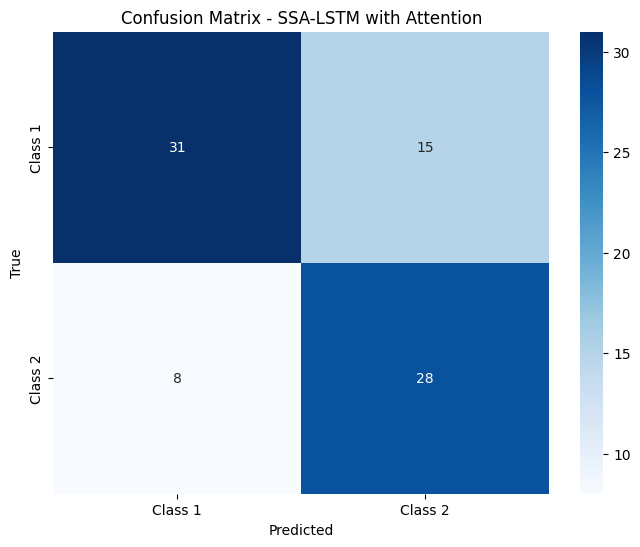

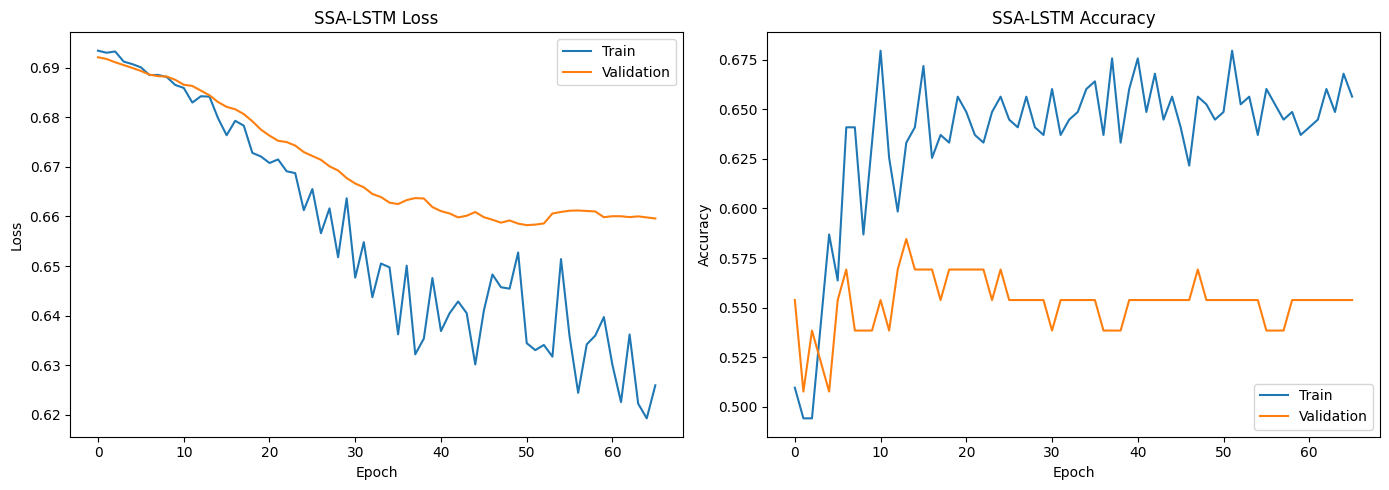

In [281]:
# Evaluate on test set
test_results = model.evaluate(X_test_lstm, y_test_lstm, verbose=1)
print(f"Test loss: {test_results[0]:.4f}")
print(f"Test accuracy: {test_results[1]:.4f}")
print(f"Test AUC: {test_results[2]:.4f}")
# Make predictions
y_pred_proba = model.predict(X_test_lstm, verbose=1)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()  # Flatten to ensure compatible shape
# Make predictions
# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nLSTM with Attention Classification Report:")
print(classification_report(y_test_lstm, y_pred))



# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test_lstm, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 1', 'Class 2'],
            yticklabels=['Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SSA-LSTM with Attention')
plt.show()

# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('SSA-LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('SSA-LSTM Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Average middle_attention_layer_3 Feature Attention: [[ 4.1947439e-11  4.3839168e-06  8.1662154e-21 -1.7300617e-13
  -9.1805923e-09  0.0000000e+00  7.6159418e-01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Average Feature Attention: [[ 0.04243009 -0.0247049   0.09470399 -0.03665525  0.0537756  -0.08275248
  -0.13265409]]


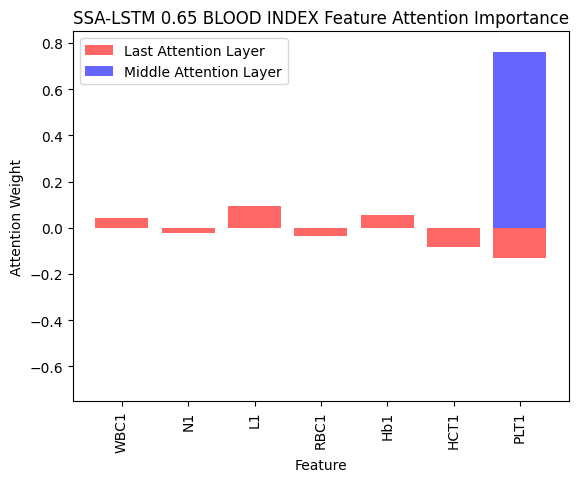

In [284]:
# Example input: (1 sample, 1 time steps, 24 features)
# example_input = np.random.rand(150, 1, 7).astype(np.float32)
example_input = x1_test[12].reshape(-1, 1, 7)
middle_attention_layer_3 = Model(inputs=model.input,
                        outputs=model.get_layer('middle_attention_layer_10').output)


middle_attention_layer_3_output = middle_attention_layer_3.predict(example_input)

middle_attention_layer_3_feature_attention = middle_attention_layer_3_output.mean(axis=1)  # (1, 24)
print("Average middle_attention_layer_3 Feature Attention:", middle_attention_layer_3_feature_attention)

# sorted_indices_middle_layer = np.argsort(middle_attention_layer_3_feature_attention)[::-1]  # Sort indices in descending order
# sorted_names_middle_layer = x1_features.to_numpy()[sorted_indices_middle_layer]
# sorted_scores_middle_layer = middle_attention_layer_3_feature_attention[0][sorted_indices_middle_layer]
# print('asda',sorted_names_middle_layer)

# ATTENTION LAYER 44
attention_layer_44 = Model(inputs=model.input,
                        outputs=model.get_layer('attention_layer_10').output)


attention_layer_44_output = attention_layer_44.predict(example_input)
# sorted_indices_last_layer = np.argsort(attention_layer_44_output)[::-1]  # Sort indices in descending order
# sorted_names_last_layer = x1_features.to_numpy()[sorted_indices_last_layer]
# sorted_scores_last_layer = attention_layer_44_output[0][sorted_indices_last_layer]

print("Average Feature Attention:", attention_layer_44_output)


plt.bar(range(7), attention_layer_44_output[0], color='red', alpha=0.6, label ='Last Attention Layer')
plt.bar(range(7), middle_attention_layer_3_feature_attention[0], color='blue', alpha=0.6, label ='Middle Attention Layer')
plt.xticks(range(7), [x1_features[i] for i in range(7)], rotation=90)
plt.title("SSA-LSTM 0.65 BLOOD INDEX Feature Attention Importance")
plt.ylabel("Attention Weight")
plt.xlabel("Feature")
plt.legend()
plt.ylim(-0.75, 0.85)

plt.show()

### FINALE TEST

In [287]:
print(type(x1_features))

<class 'pandas.core.indexes.base.Index'>


In [305]:
df_set = df.loc[:, 'Gende':'Oliguria'].copy().fillna(0)

x1_features = df_set.columns.to_list() + x1_features.to_list()

df_set = df_set.to_numpy()

# print(df_set.shape)
df_set = np.hstack((df_set, bl_arr))
# print(df_set.shape)

x1_train, x1_test, y1_train, y1_test = train_test_split(df_set, df['Diagnosis'], \
                                                    test_size=0.2, random_state=17, stratify=df['Diagnosis'])


print('x1_train shape: ', x1_train.shape, 'y1_train shape: ',  y1_train.shape)
print('x1_test shape: ', x1_test.shape, 'y1_test shape: ',  y1_test.shape)
uniques, counts = np.unique(y1_test, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y1_test), 2))))

x1_train shape:  (324, 31) y1_train shape:  (324,)
x1_test shape:  (82, 31) y1_test shape:  (82,)
percentage of classes:  {'1': np.float64(56.1), '2': np.float64(43.9)}


In [306]:
# x1_train = x1_train.to_numpy()
y1_train = y1_train.to_numpy()
# x1_test = x1_test.to_numpy()
y1_test = y1_test.to_numpy()

x1_train = x1_train.astype(np.float64)
y1_train = y1_train.astype(np.int64)
x1_test = x1_test.astype(np.float64)
y1_test = y1_test.astype(np.int64)

y1_train = y1_train - 1
y1_test = y1_test - 1

In [272]:
print(x1_train[0])

[  0.      0.      0.      1.      0.      0.      3.      0.      0.
  80.     95.     60.      1.      1.      0.      1.      0.      0.
   0.      0.      0.      0.      0.      0.      4.66   76.     12.9
   4.33  131.      0.377 316.   ]


In [293]:
# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.attention_weights = None

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Alignment scores. [batch_size, seq_len, 1]
        e = K.tanh(K.dot(x, self.W) + self.b)
        
        # Remove dimension of size 1. [batch_size, seq_len]
        e = K.squeeze(e, axis=-1)
        
        # Compute the weights. [batch_size, seq_len]
        alpha = K.softmax(e)
        
        # Reshape to [batch_size, seq_len, 1]
        alpha = K.expand_dims(alpha, axis=-1)
        
        # Compute the context vector. [batch_size, features]
        context = x * alpha
        context = K.sum(context, axis=1)
        
        return context 
    
class middleAttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(middleAttentionLayer, self).__init__(**kwargs)
        self.attention_weights = None

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(middleAttentionLayer, self).build(input_shape)

    def call(self, x):
        # Alignment scores. [batch_size, seq_len, 1]
        e = K.tanh(K.dot(x, self.W) + self.b)
        
        # # Remove dimension of size 1. [batch_size, seq_len]
        # e = K.squeeze(e, axis=-1)

        # # Compute the weights. [batch_size, seq_len]
        # alpha = K.softmax(e)
        
        # # Reshape to [batch_size, seq_len, 1]
        # alpha = K.expand_dims(alpha, axis=-1)
        
        self.attention_weights = K.softmax(e, axis=-1)

        # Compute the context vector. [batch_size, features]
        context = x * self.attention_weights
   
        return context  

def create_lstm_with_attention(input_shape, dropout_rate=0.2):
    """
    Create an LSTM model with Spatial Dropout and Attention for binary classification
    
    Args:
        input_shape: Tuple (timesteps, features) specifying input dimensions
        dropout_rate: Dropout rate to prevent overfitting
    
    Returns:
        Compiled Keras LSTM model with attention
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Spatial Dropout layer
    # This helps with overfitting by dropping entire feature maps
    x = BatchNormalization()(inputs)
    # print("x shape after BatchNormalization:", x.shape)  # Debugging line to check input shape
    # LSTM layer
    x = LSTM(31, return_sequences=True)(x)
    x = SpatialDropout1D(dropout_rate)(x)
    
    # Attention layer
    x = middleAttentionLayer()(x)

    x = LSTM(31, return_sequences=True)(x)
    x = SpatialDropout1D(dropout_rate)(x)
    x = AttentionLayer()(x)

    # Dropout for regularization
    x = Dropout(dropout_rate)(x)
 
    # Output layer
    outputs = Dense(1, activation='sigmoid')(x) 
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), 
                 tf.keras.metrics.Precision(), 
                 tf.keras.metrics.Recall()]
    )
    
    return model

In [294]:
# Assuming x1_train, y1_train, x1_test, y1_test are available from your notebook

# Prepare data 
# Option 1: Single timestep with all features
X_train_lstm, y_train_lstm, scaler = prepare_data_for_lstm(x1_train, y1_train)
# print("X_train_lstm shape:", X_train_lstm.shape)
X_test_lstm, y_test_lstm, _ = prepare_data_for_lstm(x1_test, y1_test)

# Option 2: Multiple timesteps (feature groups)
# X_train_lstm, y_train_lstm, scaler = prepare_sequence_data(x1_train, y1_train, n_steps=4)
# X_test_lstm, y_test_lstm, _ = prepare_sequence_data(x1_test, y1_test, n_steps=4)

# Create model
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])  # (timesteps, features)
# print("Input shape for LSTM with attention:", input_shape)
model = create_lstm_with_attention(input_shape)

# Model summary
model.summary()

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ModelCheckpoint('best_lstm_attention_model.h5', save_best_only=True, monitor='val_loss'),
    # Optionally add learning rate reduction callback
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001
    )
]

# Calculate class weights - important for imbalanced data
from sklearn.utils.class_weight import compute_class_weight
unique_classes = np.unique(y_train_lstm)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_lstm)
class_weight_dict = {i: weight for i, weight in zip(unique_classes, class_weights)}
print("Class weights:", class_weight_dict)

# Train model
history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=0
)



Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 1, 31)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1, 31)          │           124 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 1, 31)          │         7,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_24            │ (None, 1, 31)          │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ middle_attention_layer_12       │ (None, 1, 31)          │            32 │
│ (middleAttentionLayer)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 1, 31)          │         7,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_25            │ (None, 1, 31)          │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_12              │ (None, 31)             │            32 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 31)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            32 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,844 (61.89 KB)

 Trainable params: 15,782 (61.65 KB)

 Non-trainable params: 62 (248.00 B)

Class weights: {np.int64(0): np.float64(0.8852459016393442), np.int64(1): np.float64(1.148936170212766)}


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8165 - auc_12: 0.8485 - loss: 0.4980 - precision_12: 0.7991 - recall_12: 0.7835
Test loss: 0.4984
Test accuracy: 0.8049
Test AUC: 0.8421
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step

LSTM with Attention Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        46
           1       0.81      0.72      0.76        36

    accuracy                           0.80        82
   macro avg       0.81      0.80      0.80        82
weighted avg       0.81      0.80      0.80        82



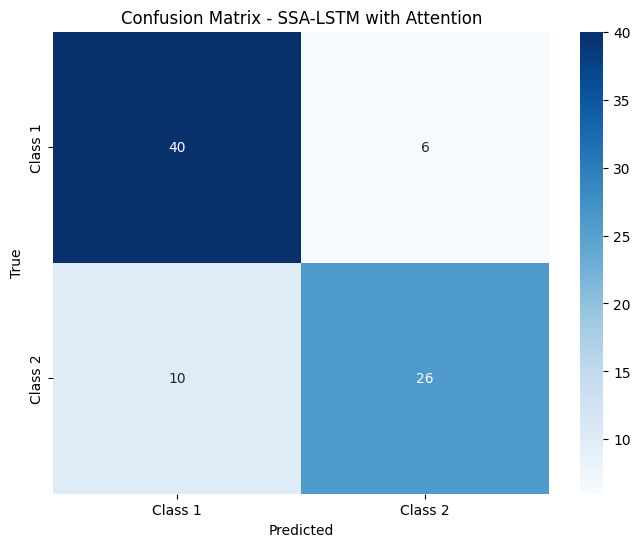

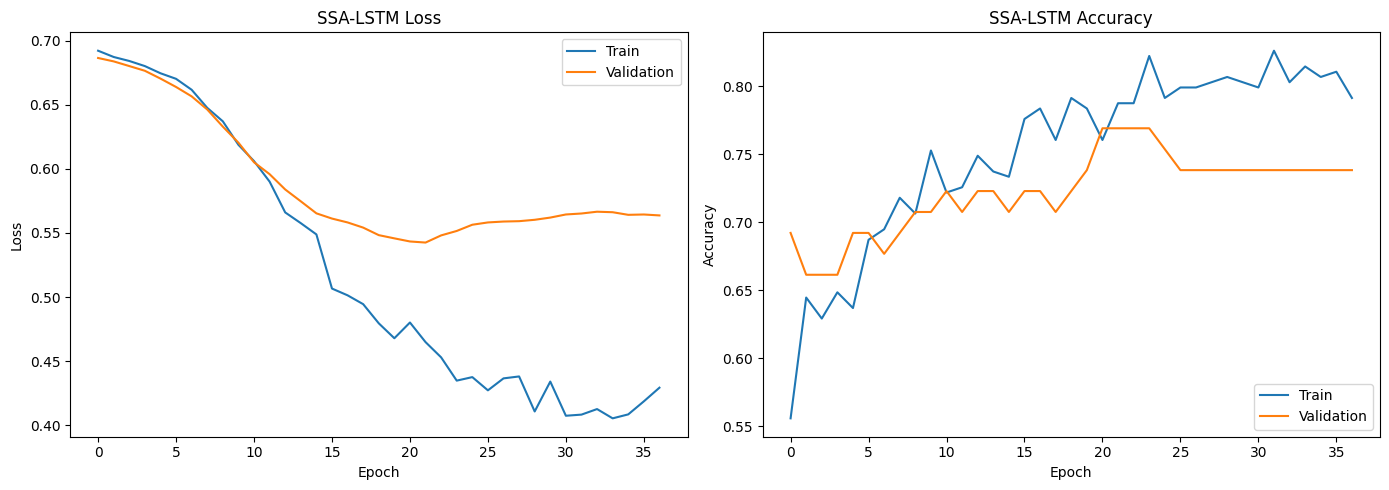

In [295]:
# Evaluate on test set
test_results = model.evaluate(X_test_lstm, y_test_lstm, verbose=1)
print(f"Test loss: {test_results[0]:.4f}")
print(f"Test accuracy: {test_results[1]:.4f}")
print(f"Test AUC: {test_results[2]:.4f}")
# Make predictions
y_pred_proba = model.predict(X_test_lstm, verbose=1)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()  # Flatten to ensure compatible shape
# Make predictions
# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nLSTM with Attention Classification Report:")
print(classification_report(y_test_lstm, y_pred))



# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test_lstm, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 1', 'Class 2'],
            yticklabels=['Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SSA-LSTM with Attention')
plt.show()

# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('SSA-LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('SSA-LSTM Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Average middle_attention_layer_3 Feature Attention: [[ 1.4095376e-18 -4.7294897e-01 -1.2992053e-14 -7.5821441e-01
   7.3975941e-09 -2.0061329e-10 -4.0084809e-30  2.5252612e-20
  -5.8449515e-14  6.6623527e-01 -1.6132801e-22 -7.6159370e-01
  -7.4427074e-01 -7.6159418e-01  9.0610530e-26 -8.9656419e-07
   7.1325587e-21  2.5287529e-35 -9.6419341e-27 -7.6159418e-01
  -7.5244313e-01 -2.1662377e-12  3.0050220e-12 -8.6758824e-05
  -2.0773962e-15  4.9875304e-01 -7.2468119e-08 -2.0316502e-14
   4.7254585e-32  7.6159418e-01  2.1319937e-18]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Average Feature Attention: [[ 0.17191638  0.02884927 -0.06927855  0.08269452  0.09495308  0.02217169
  -0.17372957  0.12888461 -0.0252274  -0.17039251 -0.01525578 -0.02602674
   0.04452698  0.02927255  0.05121202 -0.04214845  0.01590378 -0.0272298
   0.12704946  0.06949671  0.00292844  0.03989217 -0.07026147 -0.06022229
   0.0101616   0.01545074  0.00297219 -0.04522669  0.05207528 -0.

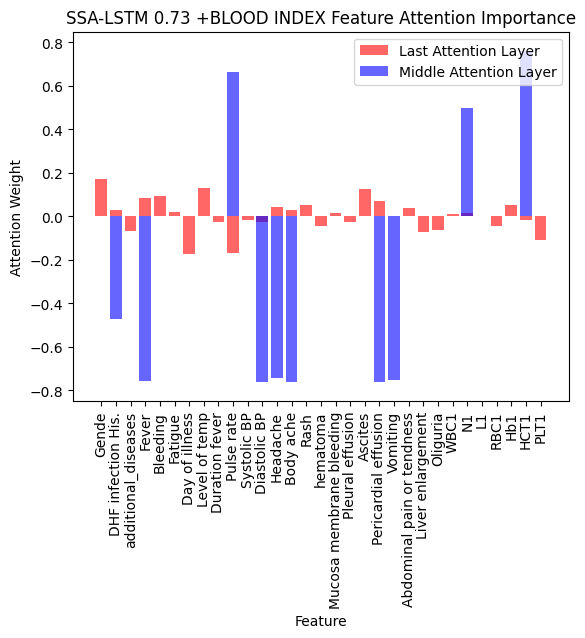

In [307]:
# Example input: (1 sample, 1 time steps, 24 features)
# example_input = np.random.rand(150, 1, 7).astype(np.float32)
example_input = x1_test[12].reshape(-1, 1, 31)
middle_attention_layer_3 = Model(inputs=model.input,
                        outputs=model.get_layer('middle_attention_layer_12').output)


middle_attention_layer_3_output = middle_attention_layer_3.predict(example_input)

middle_attention_layer_3_feature_attention = middle_attention_layer_3_output.mean(axis=1)  # (1, 24)
print("Average middle_attention_layer_3 Feature Attention:", middle_attention_layer_3_feature_attention)

# sorted_indices_middle_layer = np.argsort(middle_attention_layer_3_feature_attention)[::-1]  # Sort indices in descending order
# sorted_names_middle_layer = x1_features.to_numpy()[sorted_indices_middle_layer]
# sorted_scores_middle_layer = middle_attention_layer_3_feature_attention[0][sorted_indices_middle_layer]
# print('asda',sorted_names_middle_layer)

# ATTENTION LAYER 44
attention_layer_44 = Model(inputs=model.input,
                        outputs=model.get_layer('attention_layer_12').output)


attention_layer_44_output = attention_layer_44.predict(example_input)
# sorted_indices_last_layer = np.argsort(attention_layer_44_output)[::-1]  # Sort indices in descending order
# sorted_names_last_layer = x1_features.to_numpy()[sorted_indices_last_layer]
# sorted_scores_last_layer = attention_layer_44_output[0][sorted_indices_last_layer]

print("Average Feature Attention:", attention_layer_44_output)


plt.bar(range(31), attention_layer_44_output[0], color='red', alpha=0.6, label ='Last Attention Layer')
plt.bar(range(31), middle_attention_layer_3_feature_attention[0], color='blue', alpha=0.6, label ='Middle Attention Layer')
plt.xticks(range(31), [x1_features[i] for i in range(31)], rotation=90)
plt.title("SSA-LSTM 0.73 +BLOOD INDEX Feature Attention Importance")
plt.ylabel("Attention Weight")
plt.xlabel("Feature")
plt.legend()
plt.ylim(-0.85, 0.85)

plt.show()